# Imports

In [8]:
# General Imports
import numpy as np
import pandas as pd
import statistics
import pickle
import os
from IPython.display import display
from collections import Counter

# Fixing random state for reproducibility
np.random.seed(19680801)

# Fonctions customs
from packages.fonctions import addlabels, nan_detection, remove_duplicates

# Représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#!pip install squarify
import squarify
from math import pi
from collections import Counter

# Dates
import time
import datetime
from datetime import datetime
from datetime import timedelta

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV

# Clustering
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score

#!pip install kneed
from kneed import KneeLocator

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)

In [9]:
# Choix d'une palette de couleurs

sns.set_palette('Set2', color_codes = True)
print(sns.color_palette('Set2').as_hex())
sns.color_palette()

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [10]:
# Créer listes vides pour stocker informations des différents essais

list_methode = []
list_variables = []
list_clients = []
list_n_clusters = []
list_silhouette_score = []

# Segmentation RFM

In [11]:
########## Import des données ##########

path = '' #-> en local
filepath = os.path.join(path, 'data/df_for_rfm')

with open(filepath, 'rb') as f:
    df_rfm = pickle.load(f)

df_rfm.head()

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_item_id,product_id,seller_id,price,freight_value,seller_city,seller_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,Nb_commandes,product_category,review_time,order_time,delivery_error_time,order_preparation_time,delivery_time,shipping_limit_respect,purchase_time,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,review,product_volume_cm3,distance
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,itaquaquecetuba,SP,41.0,1141.0,1.0,8683.0,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4.0,1,"Travail de bureau, Industry & Construction",4.940741,8.812500,-10.558623,6.809549,1.991412,-0.809549,2017-05-16 15:05:35,2017.0,5.0,1.0,16.0,15.0,0,107136.0,228.795383
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,289.00,46.48,itajai,SC,43.0,1002.0,3.0,10150.0,1.0,credit_card,8.0,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,1,Maison & jardin,11.946863,16.661748,-7.471308,2.844757,13.809954,3.155243,2018-01-12 20:48:24,2018.0,1.0,4.0,12.0,20.0,0,53400.0,302.718580
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,itaquaquecetuba,SP,55.0,955.0,1.0,8267.0,1.0,credit_card,7.0,157.73,5ad6695d76ee186dc473c42706984d87,5.0,1,"Travail de bureau, Industry & Construction",0.507627,26.077153,1.749201,21.924884,3.144340,-5.924884,2018-05-19 16:07:45,2018.0,5.0,5.0,19.0,16.0,0,45968.0,29.146575
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,itaquaquecetuba,SP,48.0,1066.0,1.0,12160.0,1.0,credit_card,1.0,173.30,059a801bb31f6aab2266e672cab87bc5,5.0,1,"Travail de bureau, Industry & Construction",4.775544,14.998461,-12.330266,14.245405,0.695637,-0.285718,2018-03-13 16:06:38,2018.0,3.0,1.0,13.0,16.0,0,79968.0,18.117442
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,230.00,22.25,ibitinga,SP,61.0,407.0,1.0,5200.0,1.0,credit_card,8.0,252.25,8490879d58d6c5d7773f2739a03f089a,5.0,1,Maison & jardin,7.083241,11.461319,-5.127917,1.212396,10.235972,0.787604,2018-07-29 09:51:30,2018.0,7.0,6.0,29.0,9.0,1,23625.0,187.459595


In [12]:
df_rfm.isna().sum()

customer_id                      0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_id                      2963
order_status                  2963
order_purchase_timestamp      2963
order_item_id                 2963
product_id                    2963
seller_id                     2963
price                         2963
freight_value                 2963
seller_city                   2963
seller_state                  2963
product_name_lenght           4601
product_description_lenght    4601
product_photos_qty            4601
product_weight_g              2983
payment_sequential            2966
payment_type                  2966
payment_installments          2966
payment_value                 2966
review_id                     3824
review_score                  3824
Nb_commandes                     0
product_category              4624
review_time                   3824
order_time                    2971
delivery_error_time 

In [13]:
df_rfm.columns

Index(['customer_id', 'customer_unique_id', 'customer_city', 'customer_state',
       'order_id', 'order_status', 'order_purchase_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'price', 'freight_value', 'seller_city',
       'seller_state', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'review_id',
       'review_score', 'Nb_commandes', 'product_category', 'review_time',
       'order_time', 'delivery_error_time', 'order_preparation_time',
       'delivery_time', 'shipping_limit_respect', 'purchase_time',
       'purchase_year', 'purchase_month', 'purchase_dayofweek', 'purchase_day',
       'purchase_hour', 'review', 'product_volume_cm3', 'distance'],
      dtype='object')

In [14]:
########## Total price ##########
# Prix total = prix unitaire * quantité
df_rfm['total_price'] = df_rfm['price'] * df_rfm['order_item_id']

########## Recency ##########
# Recency = nombre de jours écoulés depuis dernier achat
# convertir date en datetime
df_rfm['order_purchase_timestamp'] = pd.to_datetime(df_rfm['order_purchase_timestamp'])

# dataset pas super récent -> on prend la date max + 1 jour à la place de la date d'aujourd'hui
now = df_rfm['order_purchase_timestamp'].max() + timedelta(days = 1)

In [15]:
########## créer RFM dataframe ##########

rfm = df_rfm.groupby('customer_unique_id').agg({
    'order_purchase_timestamp' : lambda day : (now - day.max()).days, # pour avoir temps écoulé depuis commande
    'order_id': lambda num : len(num), # nombre de commandes (fréquence)
    'total_price': lambda price : price.sum() # prix
})

# Renommer colonnes
rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112.0,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115.0,1,18.90
0000f46a3911fa3c0805444483337064,537.0,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,321.0,1,25.99
0004aac84e0df4da2b147fca70cf8255,288.0,1,180.00


### Calculating RFM Score

In [16]:
rfm['Frequency'].unique()

array([ 1,  2,  4,  3,  7,  5,  6, 12, 15,  8, 10, 18, 11,  9, 14, 24, 19,
       22, 20, 21, 26, 16, 13, 38, 17, 75, 35])

In [17]:
# les quantiles sont des points de données qui divisent un ensemble de données en des fractions égales

# calculer les quartiles
statistics.quantiles(rfm['Frequency'])

# calculer quintiles ?
statistics.quantiles(rfm['Frequency'], n = 5)

[1.0, 1.0, 1.0, 1.0]

In [18]:
rfm['Frequency'].value_counts()

1     81837
2     10391
3      2026
4       955
5       336
6       296
7        71
8        48
10       25
12       25
9        24
11       19
14        8
24        7
15        6
13        6
20        4
21        3
18        1
19        1
22        1
26        1
16        1
38        1
17        1
75        1
35        1
Name: Frequency, dtype: int64

In [19]:
print("Le nombre de clients ayant commandé plus d'une fois est de : {:.2f} %".format(100*sum(rfm['Frequency'] > 1)/len(rfm)))

Le nombre de clients ayant commandé plus d'une fois est de : 14.84 %


In [20]:
def plot_hist(rfm, figsize = (12, 7)):

    plt.figure(figsize = figsize)
    for i, col in enumerate(rfm):
        plt.subplot(len(rfm.columns), 1, i + 1)
        plt.hist(
            rfm[col],
            bins = int(1 + np.log2(len(rfm))),
            label = 'skweness : ' + str(round(rfm[col].skew(), 2)),
            density = True,
            color = '#8da0cb'
            )
        plt.ylabel("Nombre de clients (%)")
        plt.xlabel(col)
        plt.legend()
        plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
        plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
        plt.minorticks_on()
    plt.tight_layout()
    plt.show()

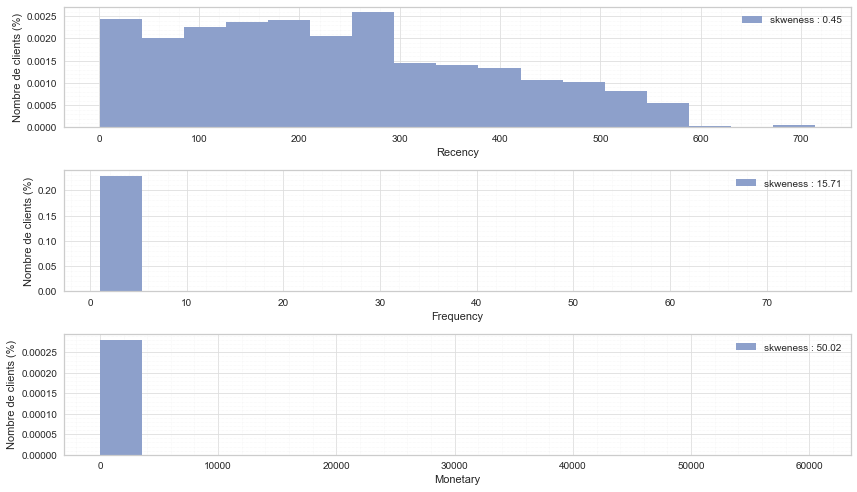

In [21]:
# Histogramme des variables 'Recency', 'Frequency' et 'Monetary'
plot_hist(rfm)

In [22]:
# Recency -> ok
# Frenquency et Monetary -> forte asymétrie
# passage au log pour corriger ça

rfm[['Frequency', 'Monetary']] = rfm[['Frequency', 'Monetary']].apply(lambda x: np.log(1 + x))

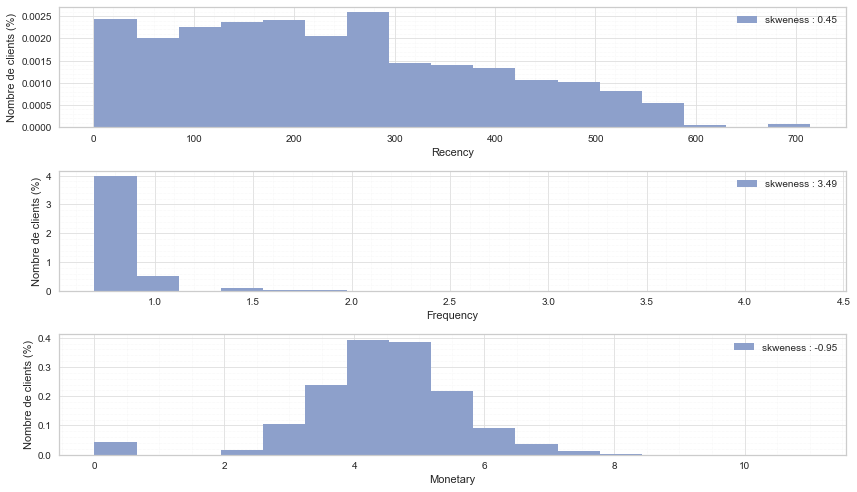

In [23]:
plot_hist(rfm)

In [24]:
# mieux - toujours pas fou pour frequency mais quand même mieux
# recency -> nombre inversés car plus c'est récent mieux c'est

In [25]:
# Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

# qcut() is Quantile-based discretization function. qcut bins the data based on sample quantiles.
# For example, 1000 values for 5 quantiles would produce a categorical object indicating quantile membership for
# each customer

"""

rfm["R"] = pd.qcut(rfm["Recency"], 5, labels = [5, 4, 3, 2, 1])
rfm["F"] = pd.qcut(rfm["Frequency"], 5, labels = [1, 2, 3, 4, 5])
rfm["M"] = pd.qcut(rfm["Monetary"], 5, labels = [1, 2, 3, 4, 5])
rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

rfm.head()

"""

# -> ne fonctionne pas
# ValueError: Bin edges must be unique: array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718, 4.15888308]).

'\n\nrfm["R"] = pd.qcut(rfm["Recency"], 5, labels = [5, 4, 3, 2, 1])\nrfm["F"] = pd.qcut(rfm["Frequency"], 5, labels = [1, 2, 3, 4, 5])\nrfm["M"] = pd.qcut(rfm["Monetary"], 5, labels = [1, 2, 3, 4, 5])\nrfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)\n\nrfm.head()\n\n'

In [26]:
# autre méthode :

def r_score(x, quintiles):
    """
    Attribue une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus la 'Recency' est faible, plus la note
    est élevé
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1


def fm_score(x, quintiles, c):
    """
    Attribue une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus x est grand, plus la note est grande
    x(float): valeur
    quintiles(dict): voir fonction calculate_quantile
    """

    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5


def calculate_quantile(rfm):
    """
    Calcul des quantiles pour chaque variable Recency, Frequency et Monetary
    puis attribue un score (fm_score et r_score) suivant la valeur
    des variables de chaque individu
    rfm(pd.DataFrame): présente les colonnes 'Recency', 'Frequency' et Monetary
    """
    quintiles = rfm[[
        'Recency',
        'Frequency',
        'Monetary'
        ]].quantile([.2, .4, .6, .8]).to_dict()

    rfm['R'] = rfm['Recency'].apply(lambda x:
                                    r_score(x, quintiles))
    rfm['F'] = rfm['Frequency'].apply(lambda x:
                                      fm_score(x, quintiles, 'Frequency'))
    rfm['M'] = rfm['Monetary'].apply(lambda x:
                                     fm_score(x, quintiles, 'Monetary'))
    return rfm

In [27]:
# Calcul des quantiles
calculate_quantile(rfm)

,Recency,Frequency,Monetary,R,F,M
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112.0,0.693147,4.874434,4,1,4
0000b849f77a49e4a4ce2b2a4ca5be3f,115.0,0.693147,2.990720,4,1,1
0000f46a3911fa3c0805444483337064,537.0,0.693147,4.248495,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,321.0,0.693147,3.295466,2,1,1
0004aac84e0df4da2b147fca70cf8255,288.0,0.693147,5.198497,2,1,4
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447.0,1.098612,7.719130,1,5,5
fffea47cd6d3cc0a88bd621562a9d061,262.0,0.693147,4.187987,3,1,2
ffff371b4d645b6ecea244b27531430a,568.0,0.693147,4.509760,1,1,3


In [28]:
rfm.isna().sum()

Recency      2738
Frequency       0
Monetary        0
R               0
F               0
M               0
dtype: int64

In [29]:
#### attention, données manquantes !...

In [30]:
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

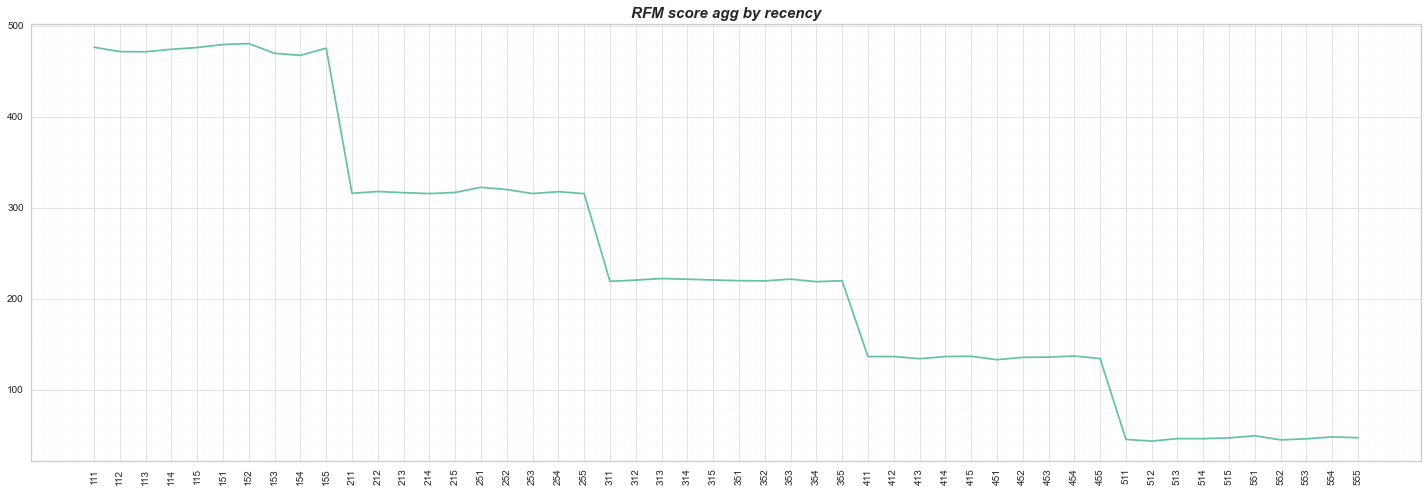

In [31]:
plt.figure(figsize = (20, 7))
plt.plot(rfm.groupby('RFM_Score').agg('Recency').mean())
plt.xticks(rotation = 90)
plt.title('RFM score agg by recency', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

### Interprétation de la segmentation

In [32]:
# exemples d'interprétation des segments RFM

#R=5, F=5, M=5 — they pay often, a lot and recently. The most loyal and active users.
#R=1, F=1, M=1 – they pay little, rarely and for a long time. Most likely lost customers. It may not be worth taking action to return them if the cost of attraction is higher than the expected profit.
#R=1/2, F=4/5, M=4/5 — loyal users on the verge of leaving. We offer them a bonus, a discount and try to return them.
#R=4/5, F=1, M=1/2/3/4/5 — Users have recently made a payment. We try to encourage them to buy more.

In [33]:
# use Recency and Frequency to segment our customers
# 10 segments based on the R and F scores

seg_map = {
    r'[1-2][1-2]': 'Hibernating', # Last purchase was long back and low number of orders. May be lost
    r'[1-2][3-4]': 'At Risk', # Purchased often but a long time ago. Need to bring them back!
    r'[1-2]5': 'Can\'t Loose', # Used to purchase frequently but haven’t returned for a long time
    r'3[1-2]': 'About to Sleep', # Below average recency and frequency. Will lose them if not reactivated
    r'33': 'Need Attention', # Above average recency, frequency and monetary values. May not have bought very recently though
    r'[3-4][4-5]': 'Loyal Customers', # Buy on a regular basis. Responsive to promotions
    r'41': 'Promising', # Recent shoppers, but haven’t spent much
    r'51': 'New Customers', # Bought most recently, but not often
    r'[4-5][2-3]': 'Potential Loyalists', # Recent customers with average frequency
    r'5[4-5]': 'Champions'    # Bought recently, buy often and spend the most
}

In [34]:
# determiner comment segmenter les clients en utilisant regex

rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex = True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112.0,0.693147,4.874434,4,1,4,414,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,115.0,0.693147,2.990720,4,1,1,411,Promising
0000f46a3911fa3c0805444483337064,537.0,0.693147,4.248495,1,1,2,112,Hibernating
0000f6ccb0745a6a4b88665a16c9f078,321.0,0.693147,3.295466,2,1,1,211,Hibernating
0004aac84e0df4da2b147fca70cf8255,288.0,0.693147,5.198497,2,1,4,214,Hibernating


In [35]:
# Grouper par cluster
group = rfm.groupby('Segment').mean().sort_values('Monetary')
group

,Recency,Frequency,Monetary,R,F,M
Segment,,,,,,
Hibernating,395.389757,0.693147,4.061539,1.457363,1.0,2.684858
About to Sleep,220.522397,0.693147,4.389760,3.000000,1.0,2.820506
New Customers,45.318853,0.693147,4.412062,5.000000,1.0,2.845205
Promising,135.791295,0.693147,4.438699,4.000000,1.0,2.876257
Can't Loose,392.906708,1.233979,5.354889,1.509541,5.0,4.098332
Loyal Customers,176.404042,1.227917,5.403219,3.509315,5.0,4.185764
Champions,46.904433,1.228884,5.405368,5.000000,5.0,4.170785


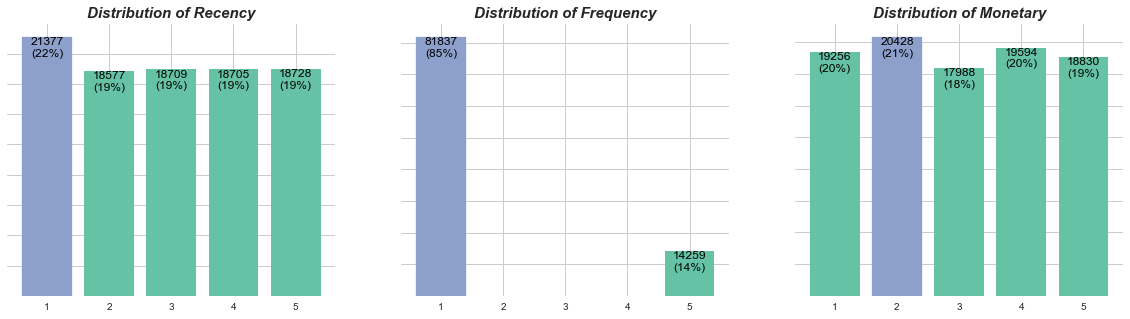

In [36]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

for i, p in enumerate(['R', 'F', 'M']):
    parameters = {'R':'Recency', 'F':'Frequency', 'M':'Monetary'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y)
    ax.set_frame_on(False)
    ax.tick_params(left = False, labelleft = False, bottom = False)
    ax.set_title('Distribution of {}'.format(parameters[p]), fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('#8da0cb')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha = 'center',
               va = 'top',
               color = 'black')

plt.show()

In [37]:
# recency et monetary sont distribués de façon relativement homogènes
# par contre frequency pas du tout

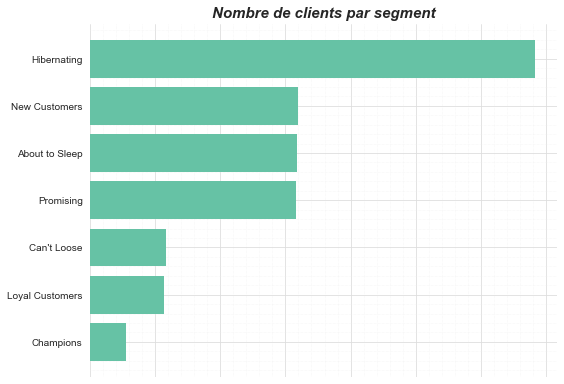

In [38]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending = True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)), segments_counts)
ax.set_frame_on(False)
ax.tick_params(left = False, bottom = False, labelbottom = False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)
plt.title('Nombre de clients par segment', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()

for i, bar in enumerate(bars):
    value = bar.get_width()
    if segments_counts.index[i] in ['champions', 'loyal customers']:
        bar.set_color('#8da0cb')
        ax.text(
            value,
            bar.get_y() + bar.get_height()/2,
            '{:,} ({:}%)'.format(int(value), int(value*100/segments_counts.sum())),
            va = 'center',
            ha = 'left'
            )

plt.show()

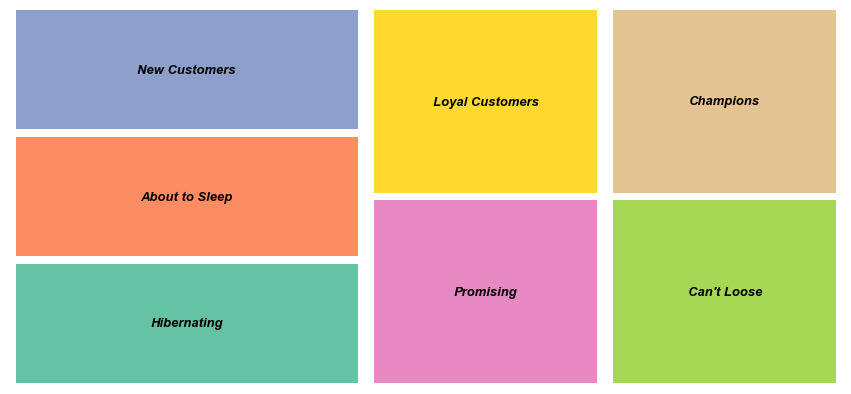

In [39]:
# Isoler valeurs et labels des clusters
values = group.index.value_counts().values
labels = group.index.value_counts().index

# Squarify plot
plt.figure(figsize = (15, 7))
squarify.plot(
    values,
    label = labels,
    text_kwargs = {'fontsize': 13, 'color': 'black', 'fontstyle' : 'italic', 'weight' : 'bold'},
    pad = 0.10,
    color = sns.color_palette('Set2', len(values))
    )
plt.axis('off')
plt.show()

In [40]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']

# Regroupement des données
qtd_preco = rfm.groupby(['Segment'])

# Aggrégation des données par différentes fonctions
summery_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)

# Affichage de la table de résumé
summery_table

Recency                                             Frequency  \
                  count    min        mean median    max        std     count   
Segment                                                                         
About to Sleep    15917  178.0  220.522397  220.0  268.0  26.526264     15917   
Can't Loose        5799  269.0  392.906708  379.0  714.0  93.239145      5817   
Champions          2752    1.0   46.904433   43.0   92.0  25.529193      2752   
Hibernating       31417  269.0  395.389757  384.0  695.0  93.513924     34137   
Loyal Customers    5690   93.0  176.404042  176.0  268.0  49.206872      5690   
New Customers     15976    1.0   45.318853   42.0   92.0  25.474302     15976   
Promising         15807   93.0  135.791295  135.0  177.0  23.688327     15807   

                                                                  Monetary  \
                      min      mean    median       max       std    count   
Segment                                                                      
About to Sleep   0.693147  0.693147  0.693147  0.693147  0.000000    15917   
Can't Loose      1.098612  1.233979  1.098612  4.330733  0.270511     5817   
Champions        1.098612  1.228884  1.098612  3.218876  0.260206     2752   
Hibernating      0.693147  0.693147  0.693147  0.693147  0.000000    34137   
Loyal Customers  1.098612  1.227917  1.098612  3.218876  0.258354     5690   
New Customers    0.693147  0.693147  0.693147  0.693147  0.000000    15976   
Promising        0.693147  0.693147  0.693147  0.693147  0.000000    15807   

                                                                    
                      min      mean    median        max       std  
Segment                                                             
About to Sleep   1.383791  4.389760  4.394326   8.213653  0.890160  
Can't Loose      0.000000  5.354889  5.298317  11.010085  1.007882  
Champions        1.686399  5.405368  5.351716   9.792612  0.944533  
Hibernating      0.000000  4.061539  4.261270   8.815222  1.484545  
Loyal Customers  2.388763  5.403219  5.374329   9.952325  0.932089  
New Customers    1.386294  4.412062  4.394264   8.814330  0.907354  
Promising        0.615186  4.438699  4.453184   8.318984  0.916088

In [41]:
rfm = rfm.drop(['R', 'F', 'M', 'RFM_Score'], axis = 1)
rfm

,Recency,Frequency,Monetary,Segment
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112.0,0.693147,4.874434,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,115.0,0.693147,2.990720,Promising
0000f46a3911fa3c0805444483337064,537.0,0.693147,4.248495,Hibernating
0000f6ccb0745a6a4b88665a16c9f078,321.0,0.693147,3.295466,Hibernating
0004aac84e0df4da2b147fca70cf8255,288.0,0.693147,5.198497,Hibernating
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447.0,1.098612,7.719130,Can't Loose
fffea47cd6d3cc0a88bd621562a9d061,262.0,0.693147,4.187987,About to Sleep
ffff371b4d645b6ecea244b27531430a,568.0,0.693147,4.509760,Hibernating


In [42]:
rfm = rfm.reset_index(drop = True)
rfm

,Recency,Frequency,Monetary,Segment
0,112.0,0.693147,4.874434,Promising
1,115.0,0.693147,2.990720,Promising
2,537.0,0.693147,4.248495,Hibernating
3,321.0,0.693147,3.295466,Hibernating
4,288.0,0.693147,5.198497,Hibernating
...,...,...,...,...
96091,447.0,1.098612,7.719130,Can't Loose
96092,262.0,0.693147,4.187987,About to Sleep
96093,568.0,0.693147,4.509760,Hibernating
96094,119.0,0.693147,4.753590,Promising


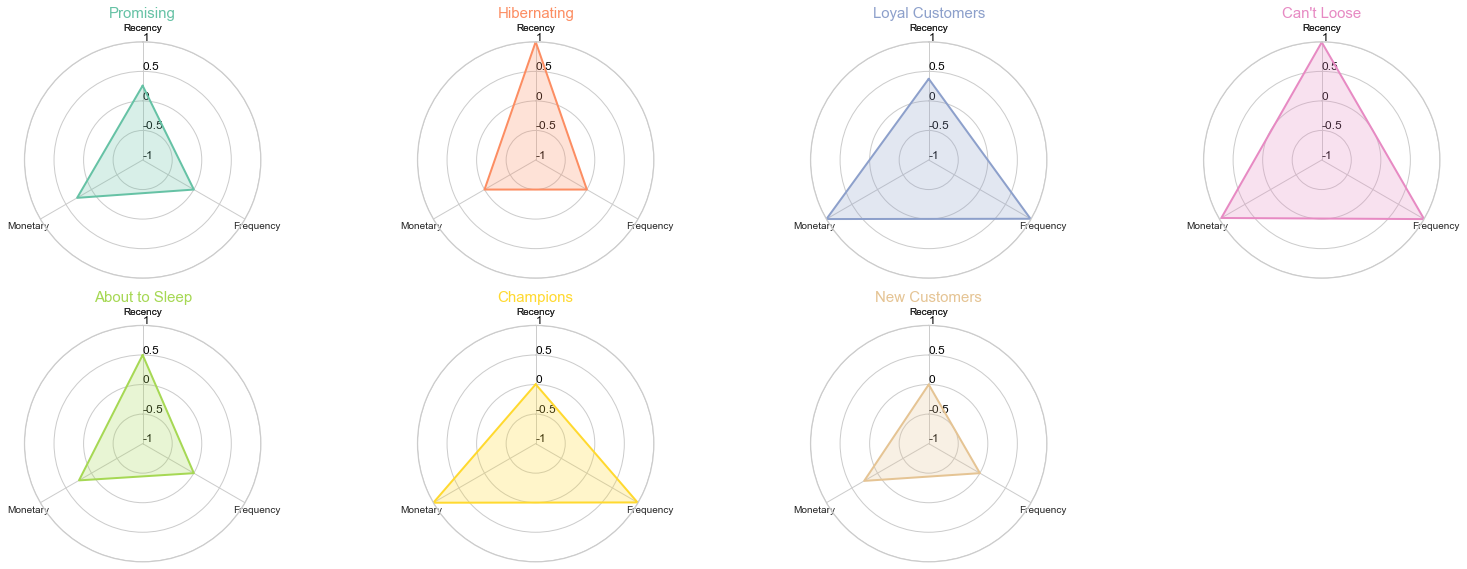

In [43]:
########## Radar plot ##########

# Lister les catégories de clients
categories = rfm['Segment'].unique()

# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette('Set2', len(categories))
colors_1 = {label: color for label, color in zip(categories, palette_1.as_hex())}
colors = colors_1

# Définir la taille du graph (nombre de subplots)
sub_plot = [4, 4]

# Aggrégation par moyenne des valeurs par segment
df_plot = rfm.groupby(['Segment']).agg('mean')

# Transformation MinMax -> [0, 1]
df_plot_std = pd.DataFrame(
    MinMaxScaler().fit_transform(df_plot),
    columns = list(df_plot.columns),
    index = df_plot.index
    )

# Noms des variables
categories = list(df_plot.columns)
# Nombre de variables
N = len(categories)

# Quel sera l'angle de chaque axe ?
# On divise un tour complet par le nombre de variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(1, figsize = (27, 20))

# Trace un radar chart pour chaque segment
for i, segment in enumerate(rfm['Segment'].unique()):
    ax = fig.add_subplot(sub_plot[0], sub_plot[1], i + 1, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)
    plt.yticks(color = 'grey', size = 2)
    values = list(df_plot_std.loc[segment].values)
    values += values[:1]
    ax.plot(angles, values, colors[segment], 'o-', linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, colors[segment], alpha = 0.25)
    ax.set_xticks(angles)
    plt.yticks(
        [-1, -0.5, 0, 0.5, 1],
        ['-1', '-0.5', '0', '0.5', '1'],
        color = 'black',
        size = 12
        )
    ax.set_title(segment, size = 15, color = colors[segment])
    ax.grid(True)
    plt.ylim(-1, 1)

plt.show()

In [44]:
########## CONCLUSION ##########

# interessant mais :
# - statique/figé -> on suppose que les clients segmentés vont maintenir leurs habitudes de consommation,
# qu'ils vont se comporter dans le futur comme ils se sont comportés dans le passé
# - méthode uniquement descriptive, ne fournit pas un moyen de prévision (contrairement à un modèle prédictif)

# frequence -> très faible pourcentage qui commande plus d'une fois donc pas
# avoir 5 groupes homogènes pour la fréquence -> super desequilibré

list_methode.append('RFM')
list_variables.append(3)
list_clients.append(rfm.shape[0])
list_n_clusters.append(7)
list_silhouette_score.append(None)

# Autres méthodes de segmentation -> clustering

## Import des données avec d'autres variables

In [45]:
########## Import des données ##########

# Chemin d'accès aux données (à modifier si code en local)
#path = '/content/drive/MyDrive/OpenClassrooms/Projet5/' #-> pour colab
path = '' #-> en local

filepath = os.path.join(path, 'data/df')

with open(filepath, 'rb') as f:
    df_final = pickle.load(f)

df_final.head()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,payment_sequential,payment_installments,payment_value,review_score,review_time,order_time,delivery_error_time,order_preparation_time,shipping_limit_respect,review,distance,Nb_commandes,order_item_id,customer_city,customer_state,payment_type,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,product_category_Eletronique et Divertissement,"product_category_Fashion, Beauté & Santé",product_category_Maison & jardin,"product_category_Travail de bureau, Industry & Construction"
0,1.167257,0.647319,-0.733865,-0.365812,-0.143138,0.072079,-0.658141,-1.725903,0.205285,-0.322790,-0.512780,1.001188,1.086596,0.724822,-0.783157,-0.277944,1.443171,0,1,1,2017.0,7.0,2.0,19.0,14.0,0,0,1,0
1,0.957866,1.327616,1.127941,1.305305,-0.143138,0.072079,-0.377872,0.685295,-0.253485,1.630269,0.304691,-0.464521,0.375678,-0.786379,0.513163,-0.277944,-0.292940,0,1,1,2018.0,2.0,2.0,14.0,11.0,0,1,0,0
2,1.062562,-0.487068,-0.733865,-0.276487,-0.143138,0.859505,-0.230308,-2.529636,-0.272668,-1.216744,-1.169459,-0.201061,1.140727,0.724822,-1.090666,-0.277944,1.443171,0,0,1,2018.0,5.0,5.0,26.0,12.0,0,0,0,1
3,1.271953,-0.537336,-0.733865,-0.537018,-0.143138,-0.715348,-0.541615,0.685295,-0.208044,-0.451719,-0.215734,-0.712737,0.602305,-0.786379,-0.299902,-0.277944,-0.292940,0,0,1,2017.0,4.0,0.0,3.0,23.0,1,0,0,0
4,-0.821955,-0.590956,-0.113263,-0.443599,-0.143138,0.859505,0.126602,-0.118437,-0.243696,0.345692,-0.670216,0.588430,-0.191630,0.724822,0.208500,-0.277944,-0.292940,0,1,1,2018.0,6.0,0.0,11.0,13.0,1,0,0,0


In [46]:
df_final.shape

(86120, 29)

# Réduction du jeu de données

In [47]:
# 29 variables -> beaucoup
# but de notre clustering -> pouvoir définir des clusters de clients et expliquer/caractériser leur comportement
# sera difficilement faisable avec 29 variables
# selectionner quelques variables (moins d'une dizaine) afin d'avoir un résultat clair

## Choix variables

In [48]:
# Lister les colonnes du df
df_final.columns

Index(['product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'payment_sequential',
       'payment_installments', 'payment_value', 'review_score', 'review_time',
       'order_time', 'delivery_error_time', 'order_preparation_time',
       'shipping_limit_respect', 'review', 'distance', 'Nb_commandes',
       'order_item_id', 'customer_city', 'customer_state', 'payment_type',
       'purchase_year', 'purchase_month', 'purchase_dayofweek', 'purchase_day',
       'purchase_hour', 'product_category_Eletronique et Divertissement',
       'product_category_Fashion, Beauté & Santé',
       'product_category_Maison & jardin',
       'product_category_Travail de bureau, Industry & Construction'],
      dtype='object')

In [49]:
df_final.reset_index(drop = True, inplace = True)

In [50]:
########## Reconstitution de la date d'achat ##########
df_final['Date_achat'] = df_final.apply(lambda row: datetime.strptime(f'{int(row.purchase_year)}-{int(row.purchase_month)}-{int(row.purchase_day)}', '%Y-%m-%d'), axis = 1)
df_final['Date_achat']

0       2017-07-19
1       2018-02-14
2       2018-05-26
3       2017-04-03
4       2018-06-11
           ...    
86115   2018-01-26
86116   2017-06-04
86117   2018-04-13
86118   2018-07-22
86119   2018-03-28
Name: Date_achat, Length: 86120, dtype: datetime64[ns]

In [51]:
########## Choix des variables (d'après résultats de l'analyse exploratoire) ##########

df_reduit = df_final[[
    #'product_name_lenght',
    #'product_description_lenght',
    #'product_photos_qty',
    'product_weight_g',
    'payment_sequential',
    #'payment_installments',
    'payment_value',
    #'review_score',
    #'review_time',
    #'order_time',
    #'delivery_error_time',
    #'order_preparation_time',
    #'shipping_limit_respect',
    'review',
    'distance',
    'Nb_commandes',
    'order_item_id',
    'customer_city',
    #'customer_state',
    'payment_type',
    #'purchase_year',
    #'purchase_month',
    #'purchase_dayofweek',
    #'purchase_day',
    #'purchase_hour',
    #'product_category_Eletronique et Divertissement',
    #'product_category_Fashion, Beauté & Santé',
    #'product_category_Maison & jardin',
    #'product_category_Travail de bureau, Industry & Construction'
    ]]

df_reduit.reset_index(drop = True, inplace = True)
df_reduit.shape

(86120, 9)

In [52]:
df_reduit

,product_weight_g,payment_sequential,payment_value,review,distance,Nb_commandes,order_item_id,customer_city,payment_type
0,-0.365812,-0.143138,-0.658141,0.724822,-0.783157,-0.277944,1.443171,0,1
1,1.305305,-0.143138,-0.377872,-0.786379,0.513163,-0.277944,-0.292940,0,1
2,-0.276487,-0.143138,-0.230308,0.724822,-1.090666,-0.277944,1.443171,0,1
3,-0.537018,-0.143138,-0.541615,-0.786379,-0.299902,-0.277944,-0.292940,0,1
4,-0.443599,-0.143138,0.126602,0.724822,0.208500,-0.277944,-0.292940,0,1
...,...,...,...,...,...,...,...,...,...
86115,-0.592846,-0.143138,-0.651689,-0.786379,0.207159,-0.277944,-0.292940,0,1
86116,-0.555627,-0.143138,-0.144086,-0.786379,0.041557,-0.277944,-0.292940,0,1
86117,-0.564932,-0.143138,-0.660096,-0.786379,-1.115925,-0.277944,-0.292940,0,1
86118,-0.558977,-0.143138,-0.045401,0.724822,0.761126,-0.277944,-0.292940,0,1


## df_sampled

In [53]:
# Certains algorithmes de clustering qu'on veut tester sont complexes -> jeu de données trop gros -> erreurs ("kernel crashed...")
# Test avec un échantillon de 10% :
df_sampled = df_reduit.sample(frac = 0.1, axis = 0)
df_sampled.reset_index(drop = True, inplace = True)
df_sampled.head()

,product_weight_g,payment_sequential,payment_value,review,distance,Nb_commandes,order_item_id,customer_city,payment_type
0,-0.574236,-0.143138,-0.672755,-0.786379,0.979350,-0.277944,-0.29294,0,0
1,-0.378839,-0.143138,-0.025947,-0.786379,-0.229303,0.936986,-0.29294,0,1
2,-0.518408,-0.143138,-0.239106,-0.786379,-0.503987,-0.277944,-0.29294,1,1
3,-0.406752,1.979736,-0.363306,-0.786379,-0.286663,-0.277944,-0.29294,0,1
4,-0.544461,-0.143138,-0.643037,-0.786379,-1.016612,-0.277944,-0.29294,0,1


## Kmeans

### GridsearchCV

In [54]:
%%time

########## GRIDSEARCH CV ##########
# -> construit une grille de modèles avec toutes les combinaisons d'hyperparamètres présents dans "param_grid"

# début de l'execution
start = time.time()

# Définir les paramètres à tester
param_grid = {
    'n_clusters' : range(2, 9),
    'n_init': [5, 10, 15], # nb d'initialisations qu'on veut faire - 10 = valeur par défaut
    'max_iter': [100, 200, 300, 400, 500], # nb d'itérations max - par défaut 300
    'init' : ['k-means++', 'random'], # quelle stratégie d'initialisation on utilise
    'tol' : [0.0001, 0.001, 0.01],
    'algorithm' : ['auto', 'full', 'elkan'],
    'random_state' : [0, 42, 100]
    }

# K-Means++ -> méthode d'initialisation qui consiste à placer les centroïdes sur des points du dataset éloignés les uns des autres - facilite convergence

# Créer l'objet Kmeans
kmeans = KMeans(random_state = 42)

# Grid Search CV
grid = GridSearchCV(
    kmeans,
    param_grid,
    cv = 5,
    verbose = 1,
    n_jobs = -1
    )

# Fit sur les données
grid.fit(df_reduit)

# fin de l'execution
end = time.time()
temps = end - start

# Meilleur score obtenu: best_score_
print(f'\nBest score = {grid.best_score_}')

# Optimal hyperparameters: best_params_
print(f'Best parameters = {grid.best_params_}')

# Nombre optimal de clusters
print('Nombre optimal de clusters = ' + str(grid.best_params_['n_clusters']))

Fitting 5 folds for each of 5670 candidates, totalling 28350 fits

Best score = -54441.2220438011
Best parameters = {'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 8, 'n_init': 15, 'random_state': 100, 'tol': 0.01}
Nombre optimal de clusters = 8
CPU times: user 2min 37s, sys: 1min 9s, total: 3min 46s
Wall time: 48min 12s


In [55]:
# to do -> faire une fonction gridsearch pour pouvoir la réutiliser facilement les prochaines fois

### Choix du K optimal

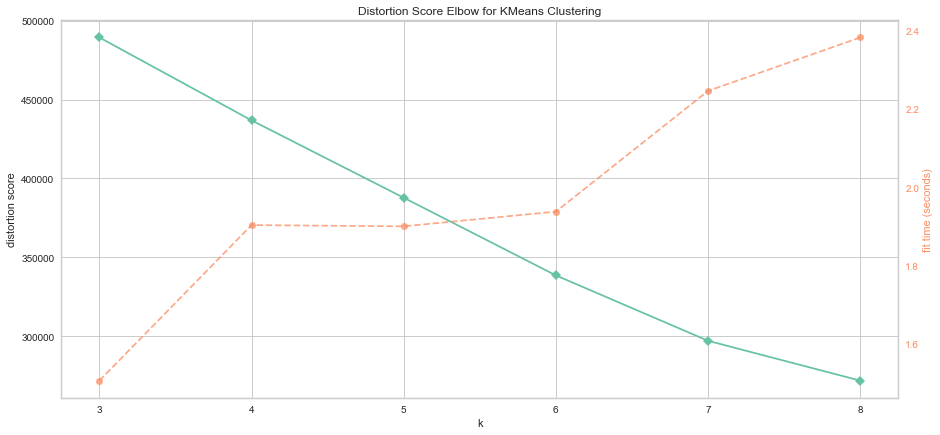

CPU times: user 1min 1s, sys: 25.3 s, total: 1min 27s
Wall time: 12.5 s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
%%time

# KElbowVisualizer - 'distortion' metric (default metric)
# Instantiate the clustering model and visualizer
model = KMeans()
d_visualizer = KElbowVisualizer(
    model,
    k = (3, 9),
    size = (1080, 500),
    metric = 'distortion'
    )

# Fit the data to the visualizer
d_visualizer.fit(df_reduit)
#d_visualizer.fit(df_final.drop(['Date_achat'], axis = 1))

# Finalize and render the figure
d_visualizer.show()

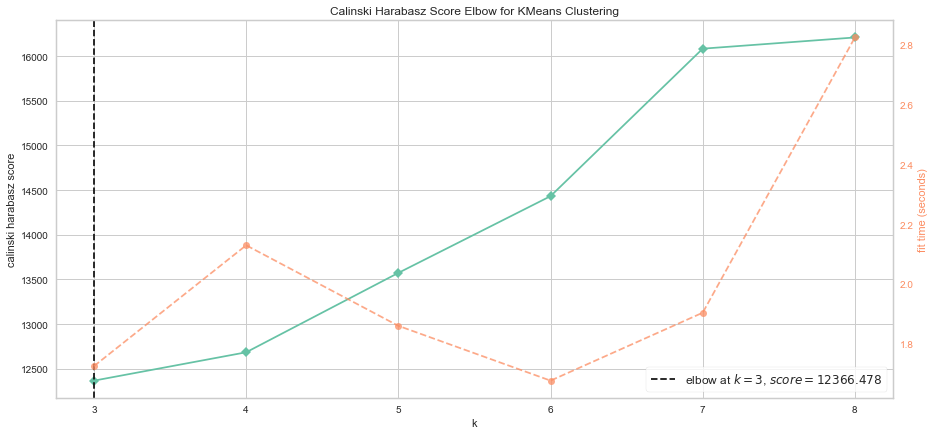

CPU times: user 1min 1s, sys: 28.7 s, total: 1min 29s
Wall time: 12.8 s


<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [57]:
%%time

# KElbowVisualizer - 'calinski_harabasz' metric
# Instantiate the clustering model and visualizer
model = KMeans()
ch_visualizer = KElbowVisualizer(
    model,
    k = (3, 9),
    size = (1080, 500),
    metric = 'calinski_harabasz'
    )

# Fit the data to the visualizer
ch_visualizer.fit(df_reduit)
#ch_visualizer.fit(df_final.drop(['Date_achat'], axis = 1))

# Finalize and render the figure
ch_visualizer.show()

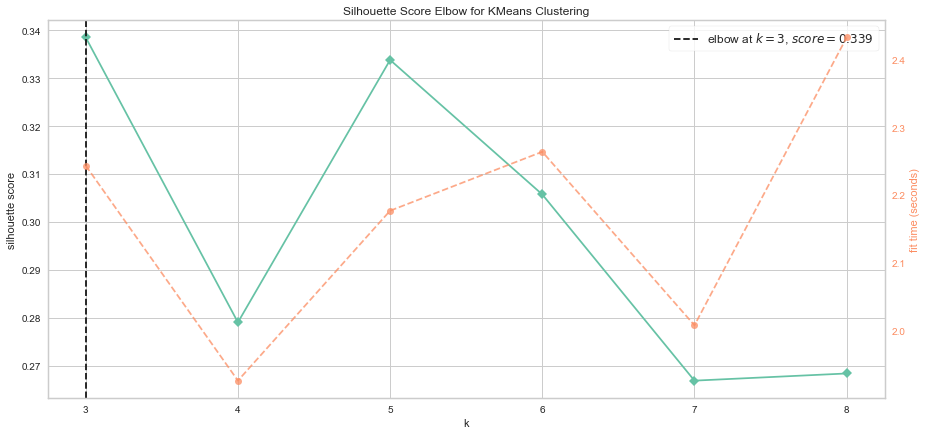

CPU times: user 15min 58s, sys: 5min, total: 20min 59s
Wall time: 6min 22s


<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [58]:
%%time

# KElbowVisualizer - 'silhouette' metric (le plus long)
# Instantiate the clustering model and visualizer
model = KMeans()
s_visualizer = KElbowVisualizer(
    model,
    k = (3, 9),
    size = (1080, 500),
    metric = 'silhouette'
    )

# Fit the data to the visualizer
s_visualizer.fit(df_reduit)
#s_visualizer.fit(df_final.drop(['Date_achat'], axis = 1))

# Finalize and render the figure
s_visualizer.show()

In [59]:
# Comparer le k optimal des différentes métriques :

# distortion
k_distortion = d_visualizer.elbow_value_
print(f'Nombre optimal de clusters - distortion metric : k = {k_distortion}')

# calinski harabasz
k_calinski_harabasz = ch_visualizer.elbow_value_
print(f'Nombre optimal de clusters - calinski harabasz metric : k = {k_calinski_harabasz}')

# silhouette
k_silhouette = s_visualizer.elbow_value_
print(f'Nombre optimal de clusters - silhouette metric : k = {k_silhouette}')

Nombre optimal de clusters - distortion metric : k = None
Nombre optimal de clusters - calinski harabasz metric : k = 3
Nombre optimal de clusters - silhouette metric : k = 3


In [60]:
########## Choix de k ##########
k = 3

## KMeans

In [61]:
# Best parameters = {'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 8, 'n_init': 15, 'random_state': 100, 'tol': 0.01}

In [62]:
%%time

# Entrainer le modèle en utilisant les paramètres définis grace aux tests précedants (coude, silhouette, gridsearch)
model = KMeans(
    n_clusters = k, # nb de clusters qu'on veut avoir
    n_init = 15, # nb d'initialisations qu'on veut faire - 10 = valeur par défaut
    max_iter = 100, # nb d'itérations max - par défaut 300
    init = 'k-means++', # quelle stratégie d'initialisation on utilise
    tol = 0.01,
    algorithm = 'auto',
    random_state = 100
    )

# Entrainer le modèle
model.fit(df_reduit)
model.predict(df_reduit)

CPU times: user 5.64 s, sys: 1.55 s, total: 7.19 s
Wall time: 1.18 s


array([0, 2, 0, ..., 0, 0, 0], dtype=int32)

In [63]:
# Centroids (= centres des clusters)
centroids = model.cluster_centers_
print(f'Shape des centroides : {centroids.shape}')

centroids

Shape des centroides : (3, 9)


array([[-0.29340145,  0.01314868, -0.23936865, -0.14790879,  0.01302289,
        -0.17248638, -0.1269892 ,  0.15516047,  0.76463288],
       [-0.07578659, -0.07507777,  1.65344427,  1.29009335,  0.0261408 ,
         1.52468023,  1.13625724,  0.16032546,  0.70547788],
       [ 2.5923513 , -0.03161554,  0.26665042, -0.12445878, -0.13960719,
        -0.16692316, -0.13770525,  0.15522351,  0.76376883]])

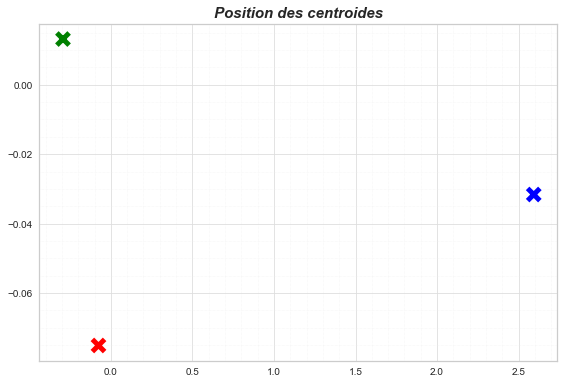

In [64]:
# Plot centroids
plt.figure()
plt.scatter(centroids[:,0], centroids[:,1], marker = 'x', s = 150, linewidths = 5, zorder = 10, c = ['green', 'red', 'blue'])
plt.title('Position des centroides', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

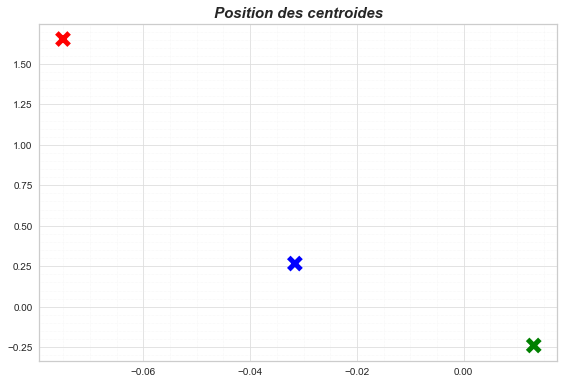

In [65]:
# Plot centroids
plt.figure()
plt.scatter(centroids[:,1], centroids[:,2], marker = 'x', s = 150, linewidths = 5, zorder = 10, c = ['green', 'red', 'blue'])
plt.title('Position des centroides', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

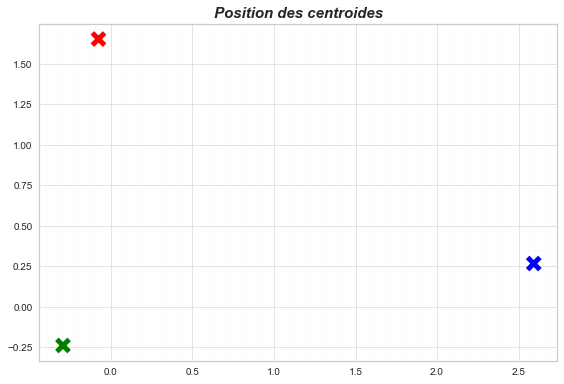

In [66]:
# Plot centroids
plt.figure()
plt.scatter(centroids[:,0], centroids[:,2], marker = 'x', s = 150, linewidths = 5, zorder = 10, c = ['green', 'red', 'blue'])
plt.title('Position des centroides', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [67]:
########## SILHOUETTE SCORE ##########
# évaluation de la qualité du clustering
# A score closer to 1 indicates that the clustering is good, while a score closer to -1 indicates that the clustering is bad.
silhouette_kmeans = round(silhouette_score(df_reduit, model.fit_predict(df_reduit)), 2)
print('The average silhouette score is:', silhouette_kmeans)

The average silhouette score is: 0.34


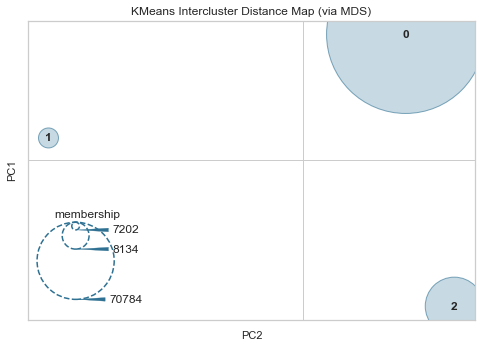

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [68]:
########## Distance intercluster ##########
# Intercluster distance Map with best k

distance_visualizer = InterclusterDistance(KMeans(k))
distance_visualizer.fit(df_reduit)
distance_visualizer.show()

In [69]:
########## CONCLUSIONS ##########
# Silhouette score de 0.28 -> bof bof
# 3 clusters bien distincts
# un des 3 clusters semble bien plus petit que les autres (en terme d'effectif)

list_methode.append('Kmeans')
list_variables.append(df_reduit.shape[1])
list_clients.append(df_reduit.shape[0])
list_n_clusters.append(3)
list_silhouette_score.append(silhouette_kmeans)

### Description des clusters

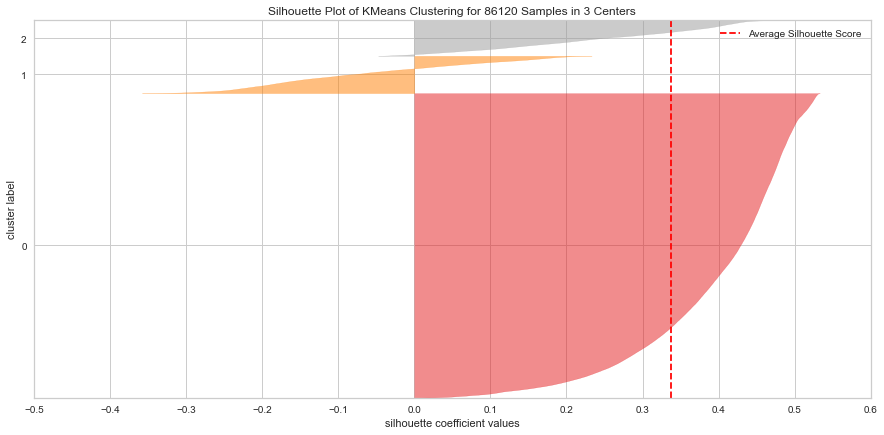

CPU times: user 5min 8s, sys: 1min 25s, total: 6min 34s
Wall time: 2min 11s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 86120 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [70]:
%%time
########## Visualisation des clusters ##########

# Instantiate the clustering model and visualizer
visualizer = SilhouetteVisualizer(model, size = (1080, 500))

# Fit the data to the visualizer
visualizer.fit(df_reduit)

# Finalize and render the figure
visualizer.show()

In [71]:
# Créer une copie du df pour ajouter les clusters et observer leur comportement
df_clusters = df_reduit

labels = model.labels_
df_clusters['cluster_num'] = labels
df_clusters.head()

,product_weight_g,payment_sequential,payment_value,review,distance,Nb_commandes,order_item_id,customer_city,payment_type,cluster_num
0,-0.365812,-0.143138,-0.658141,0.724822,-0.783157,-0.277944,1.443171,0,1,0
1,1.305305,-0.143138,-0.377872,-0.786379,0.513163,-0.277944,-0.292940,0,1,2
2,-0.276487,-0.143138,-0.230308,0.724822,-1.090666,-0.277944,1.443171,0,1,0
3,-0.537018,-0.143138,-0.541615,-0.786379,-0.299902,-0.277944,-0.292940,0,1,0
4,-0.443599,-0.143138,0.126602,0.724822,0.208500,-0.277944,-0.292940,0,1,0


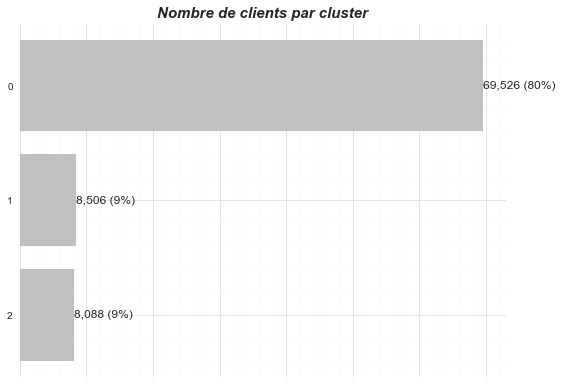

In [72]:
# Nombre de clients dans chaque cluster
segments_counts = df_clusters['cluster_num'].value_counts().sort_values(ascending = True)

# Plot
fig, ax = plt.subplots()
bars = ax.barh(
        range(len(segments_counts)),
        segments_counts,
        color = 'silver'
        )
ax.set_frame_on(False)
ax.tick_params(left = False, bottom = False, labelbottom = False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)
for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value), int(value*100/segments_counts.sum())),
                va = 'center',
                ha = 'left'
               )
plt.title('Nombre de clients par cluster', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [73]:
# Attention au volume des clusters
# si cluster avec moins de 500 individus -> risqué - clustering à revoir

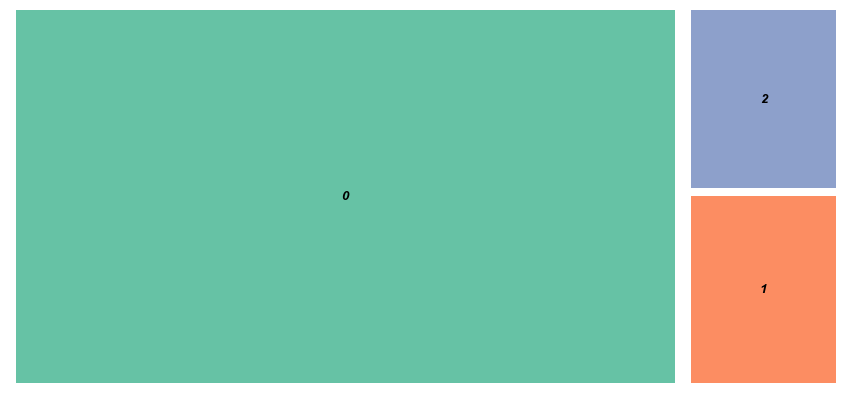

In [74]:
#Autre forme de visualisation

# Isoler valeurs et labels des clusters
values = df_clusters['cluster_num'].value_counts().values
labels = df_clusters['cluster_num'].value_counts().index

# Squarify plot
plt.figure(figsize = (15, 7))
squarify.plot(
    values,
    label = labels,
    text_kwargs = {'fontsize': 13, 'color': 'black', 'fontstyle' : 'italic', 'weight' : 'bold'},
    pad = 0.10,
    color = sns.color_palette('Set2', len(values))
    )
plt.axis('off')
plt.show()

In [75]:
# Faire la moyenne pour expliquer les clusters
df_clusters.groupby('cluster_num').mean().reset_index(drop = True)

,product_weight_g,payment_sequential,payment_value,review,distance,Nb_commandes,order_item_id,payment_type
0,-0.292946,0.012805,-0.237097,-0.145304,0.012967,-0.170703,-0.123256,0.764347
1,-0.072277,-0.074732,1.685258,1.305780,0.026925,1.553307,1.137504,0.706207
2,2.594229,-0.031478,0.265776,-0.124201,-0.139783,-0.166185,-0.136762,0.763848


In [76]:
df_clusters.columns

Index(['product_weight_g', 'payment_sequential', 'payment_value', 'review',
       'distance', 'Nb_commandes', 'order_item_id', 'customer_city',
       'payment_type', 'cluster_num'],
      dtype='object')

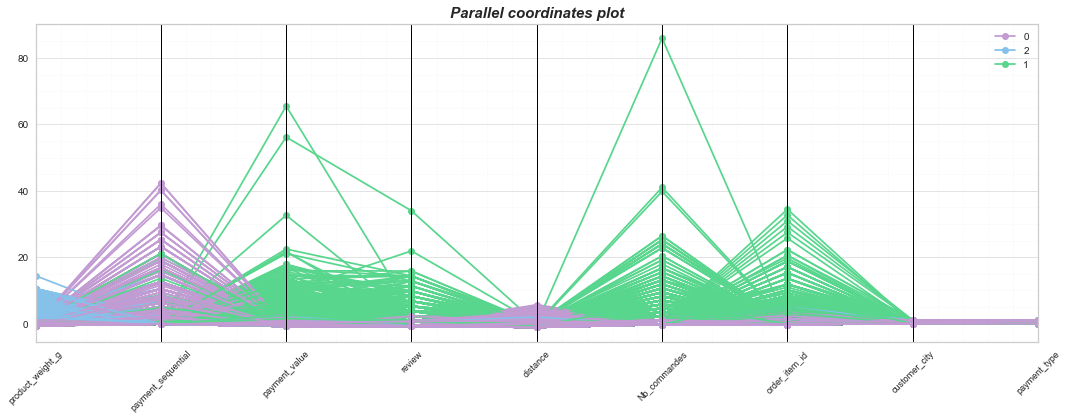

In [77]:
# Parallel_coordinates plot
# https://www.data-to-viz.com/graph/parallel.html

plt.figure(figsize = (15, 6))
pd.plotting.parallel_coordinates(df_clusters, 'cluster_num', marker = 'o', color = ['#c39bd3', '#85c1e9', '#58d68d'])
plt.xticks(fontsize = 9, rotation = 45)
plt.title('Parallel coordinates plot', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

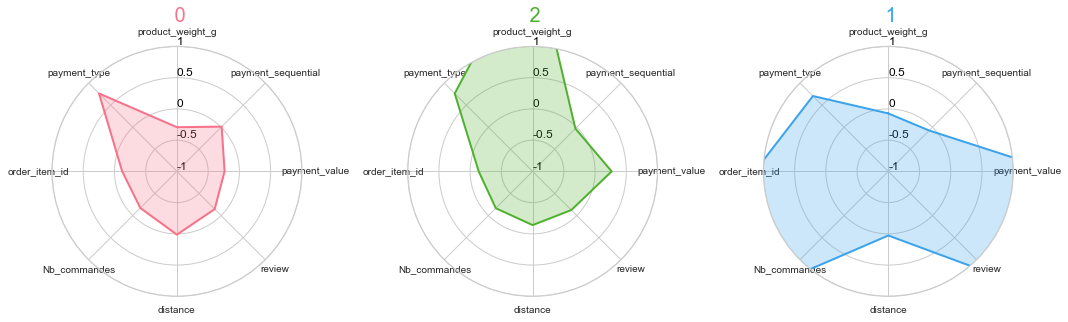

In [78]:
########## Radar plot ##########

clusters_customers = df_clusters['cluster_num'].unique()

# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette('husl', len(clusters_customers))
colors = {label: color for label, color in zip(clusters_customers, palette_1.as_hex())}

# Aggrégation par moyenne des valeurs par segment (A faire pour aller plus loin -> trouver un autre moyen d'agg que la moyenne)
df_plot = df_clusters.groupby(['cluster_num']).agg('mean')

# Noms des variables
categories = list(df_plot.columns)

# Nombre de variables
N = len(categories)

# Définir l'angle entre chaque axe
# -> On divise un tour complet par le nombre de variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(1, figsize = (15, 15))

# Trace un radar chart pour chaque segment
for i, segment in enumerate(df_clusters['cluster_num'].unique()):
    ax = fig.add_subplot(1, 3, i + 1, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Tracer un axe par variable et ajouter les labels
    plt.xticks(angles[:-1], categories)
    plt.yticks(color = 'grey', size = 2)
    values = list(df_plot.loc[segment].values)
    values += values[:1]
    ax.plot(angles, values, colors[segment], 'o-', linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, colors[segment], alpha = 0.25)
    plt.yticks([-1, -0.5, 0, 0.5, 1], ['-1', '-0.5', '0', '0.5', '1'], color = 'black', size = 12)
    ax.set_title(f' {segment}', size = 20, color = colors[segment])
    ax.grid(True)
    plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

In [79]:
########## Nommer les clusters ##########

df_clusters['cluster_num'].replace({
    0 :'curieux', # achètent un petit produit peu cher une seule fois, ne laissent pas de commentaire, paient en une seule fois
    1 :'fidèles', # acheteurs réguliers, achètent plusieurs fois plusieurs petits produits, dépensent le plus d'argent, paient en peu de fois, laissent des reviews
    2 :'achats uniques mais volumineux' # achètent une seule fois mais un ou plusieurs produits lourds, commandes plus onéreuses que clients "curieux", paient en plusieurs fois
    }, inplace = True)

df_clusters.head()

,product_weight_g,payment_sequential,payment_value,review,distance,Nb_commandes,order_item_id,customer_city,payment_type,cluster_num
0,-0.365812,-0.143138,-0.658141,0.724822,-0.783157,-0.277944,1.443171,0,1,curieux
1,1.305305,-0.143138,-0.377872,-0.786379,0.513163,-0.277944,-0.292940,0,1,achats uniques mais volumineux
2,-0.276487,-0.143138,-0.230308,0.724822,-1.090666,-0.277944,1.443171,0,1,curieux
3,-0.537018,-0.143138,-0.541615,-0.786379,-0.299902,-0.277944,-0.292940,0,1,curieux
4,-0.443599,-0.143138,0.126602,0.724822,0.208500,-0.277944,-0.292940,0,1,curieux


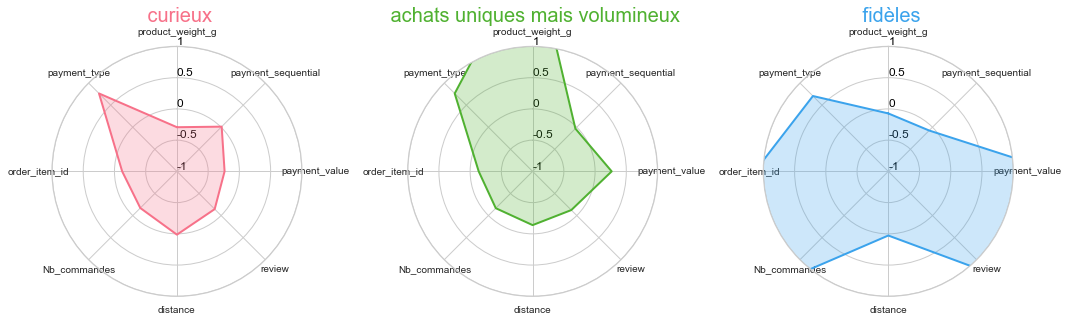

In [80]:
########## Radar plot ##########

clusters_customers = df_clusters['cluster_num'].unique()

# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette('husl', len(clusters_customers))
colors = {label: color for label, color in zip(clusters_customers, palette_1.as_hex())}

# Aggrégation par moyenne des valeurs par segment (A faire pour aller plus loin -> trouver un autre moyen d'agg que la moyenne)
df_plot = df_clusters.groupby(['cluster_num']).agg('mean')

# Noms des variables
categories = list(df_plot.columns)

# Nombre de variables
N = len(categories)

# Définir l'angle entre chaque axe
# -> On divise un tour complet par le nombre de variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(1, figsize = (15, 15))

# Trace un radar chart pour chaque segment
for i, segment in enumerate(df_clusters['cluster_num'].unique()):
    ax = fig.add_subplot(1, 3, i + 1, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Tracer un axe par variable et ajouter les labels
    plt.xticks(angles[:-1], categories)
    plt.yticks(color = 'grey', size = 2)
    values = list(df_plot.loc[segment].values)
    values += values[:1]
    ax.plot(angles, values, colors[segment], 'o-', linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, colors[segment], alpha = 0.25)
    plt.yticks([-1, -0.5, 0, 0.5, 1], ['-1', '-0.5', '0', '0.5', '1'], color = 'black', size = 12)
    ax.set_title(f' {segment}', size = 20, color = colors[segment])
    ax.grid(True)
    plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

In [81]:
############ Description des différents clusters ##########

#### Cluster 0 = plus gros cluster, regroupe plus de 50% des clients

# Clients 'curieux'
# -> commandent 1 fois 1 produit pas cher pas lourd, paient en une fois, ne laissent pas de review

#### Cluster 2

# clients qui achètent une seule fois mais un ou plusieurs produits lourds, commandes plus onéreuses que clients "curieux", paient en plusieurs fois

#### Cluster 1

# Client 'fidèles'/'réguliers'
# acheteurs réguliers, achètent plusieurs fois plusieurs petits produits, dépensent le plus d'argent, paient en peu de fois, laissent des reviews

########## Conclusions ##########

# analyse effectuée sur la totalité du jeu de données clients
# silhouette score bas mais acceptable
# comportements clients bien définis

In [82]:
df_clusters.columns

Index(['product_weight_g', 'payment_sequential', 'payment_value', 'review',
       'distance', 'Nb_commandes', 'order_item_id', 'customer_city',
       'payment_type', 'cluster_num'],
      dtype='object')

In [83]:
# Cluster interpretation

# https://python.plainenglish.io/a-comprehensive-guide-to-customer-segmentation-in-python-with-kmeans-a04068f8c3c
# https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering
# à lire

## DBSCAN

In [84]:
# DBSCAN = Density Based Spatial Clustering of Applications with Noise

# https://datascientest.com/machine-learning-clustering-dbscan#:~:text=Le%20DBSCAN%20est%20un%20algorithme%20simple%20qui%20d%C3%A9finit%20des%20clusters,estimation%20de%20la%20densit%C3%A9%20locale.
# Le DBSCAN est un algorithme simple qui définit des clusters en utilisant l’estimation de la densité locale

# https://www.reneshbedre.com/blog/dbscan-python.html

### Choix des paramètres

In [85]:
# Impossible de faire une gridsearchcv pour dbscan car pas de méthode de scoring
### https://stackoverflow.com/questions/25633383/how-can-gridsearchcv-be-used-for-clustering-meanshift-or-dbscan

# Paramètres à définir : epsilon et min_samples
# itérer sur valeurs de epsilon et de min_samples et voir le nb de clusters obtenus ainsi que leurs effectifs

In [86]:
df_dbscan = df_sampled.copy()

In [87]:
########## min_samples ##########
# min_samples -> nombre minimum requis de points dans ce cercle pour que le point soit classifié comme point 'core'

# min_samples = 2 * number of dimensions
min_samples = 2 * df_dbscan.shape[1]
min_samples

18

In [88]:
########## Epsilon ##########
# epsilon -> rayon du cercle créé autour de chaque point pour checker densité

pd.np.arange(0.1, 7, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9])

In [89]:
%time

# Test sur jeu de données complet -> kernel crash
# Test sur jeu données sous-échantillonné :
dbscan_clusters = []
list_epsilon = pd.np.arange(0.1, 7, 0.1)
list_min_samples = [5, 10, 50, 100, 200]

n_iterations = 0
for eps_val in list_epsilon:
    for min_s in list_min_samples:
        dbscan_grid = DBSCAN(eps = eps_val, min_samples = min_s)
        # fit transform
        clusters = dbscan_grid.fit_predict(X = df_dbscan)
        # saving the number of clusters
        n_clusters = len(set(clusters)) - 1
        # counting the amount of data in each clusters
        cluster_count = Counter(clusters)
        # inscrising n iter
        n_iterations += 1
        # concerver valeurs pour lesquelles on obtient 2 à 9 clusters contenants au moins 500 individus
        if n_clusters > 2 and n_clusters < 15 and all(element >= 500 for element in [cluster_count[c] for c in cluster_count.keys()]):
            #print(f'Conditions vérifiée !! Paramètres epsilon = {eps_val}, min_samples = {min_s} ')
            dbscan_clusters.append([eps_val, min_s, n_clusters, cluster_count])
        else:
            pass
            #print(f'Paramètres epsilon = {eps_val}, min_samples = {min_s} non retenus - {n_clusters} clusters, balance : {cluster_count}')

print(f"Nombre d'itérations effectuées : {n_iterations}")
print('Paramètres et nombre de clusters retenus :')
dbscan_clusters

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs
Nombre d'itérations effectuées : 345
Paramètres et nombre de clusters retenus :


[]

In [90]:
# '-1' value represents noisy points could not assigned to any cluster

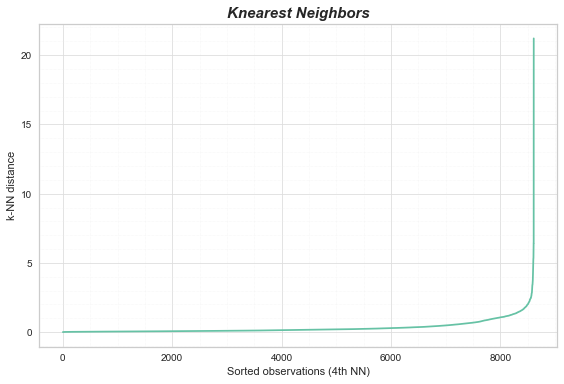

In [91]:
########## Autre façon de déterminer epsilon ##########
# NearestNeighbors et KneeLocator

########## NearestNeighbors ###########
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
nbrs = NearestNeighbors(n_neighbors = 3).fit(df_dbscan)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(df_dbscan)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:, 2]
plt.plot(k_dist)
plt.title('Knearest Neighbors', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.ylabel('k-NN distance')
plt.xlabel('Sorted observations (4th NN)')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

Estimation du point d'inflexion (coude): 4.125011673098557


<Figure size 576x396 with 0 Axes>

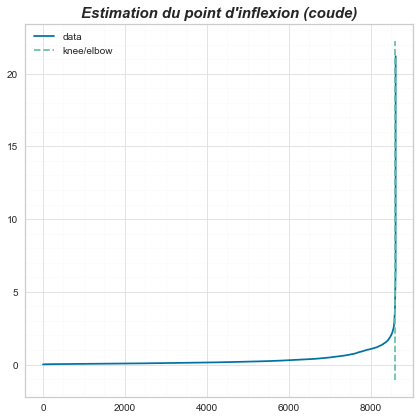

In [92]:
########## KneeLocator ##########
kneedle = KneeLocator(
    x = range(1, len(neigh_dist) + 1),
    y = k_dist,
    S = 1.0,
    curve = 'concave',
    direction = 'increasing',
    online = True
    )

# get the estimate of knee point
print(f"Estimation du point d'inflexion (coude): {kneedle.knee_y}")

# Plot
plt.figure()
kneedle.plot_knee()
plt.title("Estimation du point d'inflexion (coude)", fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [93]:
# puis utiliser cet optimum pour le dbscan clustering
eps = kneedle.knee_y
eps

4.125011673098557

### Dbscan

In [94]:
df_dbscan.columns

Index(['product_weight_g', 'payment_sequential', 'payment_value', 'review',
       'distance', 'Nb_commandes', 'order_item_id', 'customer_city',
       'payment_type'],
      dtype='object')

In [95]:
# pas de paramètres satisfaisants retenus avec méthodes précédantes... tester néamoins avec
eps = 0.5
min_samples = 100

In [96]:
db = DBSCAN(eps = eps, min_samples = min_samples).fit(df_dbscan)

# get cluster labels
db_labels = db.labels_
db_labels

array([-1, -1,  4, ..., -1, -1, -1])

In [97]:
# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 4767


In [98]:
# check unique clusters
set(db_labels) # -1 value represents noisy points could not assigned to any cluster

{-1, 0, 1, 2, 3, 4}

In [99]:
# Get each cluster size
Counter(db_labels)

Counter({-1: 4767, 4: 222, 0: 1808, 1: 1115, 2: 426, 3: 274})

In [100]:
y_pred = DBSCAN(eps = eps, min_samples = min_samples).fit_predict(df_dbscan)
y_pred

array([-1, -1,  4, ..., -1, -1, -1])

In [101]:
# Evaluation du clustering : silhouette score
silhouette_dbscan = round(silhouette_score(df_dbscan, y_pred), 2)
print('The average silhouette score is:', silhouette_dbscan)

The average silhouette score is: -0.03


In [102]:
df_dbscan

,product_weight_g,payment_sequential,payment_value,review,distance,Nb_commandes,order_item_id,customer_city,payment_type
0,-0.574236,-0.143138,-0.672755,-0.786379,0.979350,-0.277944,-0.292940,0,0
1,-0.378839,-0.143138,-0.025947,-0.786379,-0.229303,0.936986,-0.292940,0,1
2,-0.518408,-0.143138,-0.239106,-0.786379,-0.503987,-0.277944,-0.292940,1,1
3,-0.406752,1.979736,-0.363306,-0.786379,-0.286663,-0.277944,-0.292940,0,1
4,-0.544461,-0.143138,-0.643037,-0.786379,-1.016612,-0.277944,-0.292940,0,1
...,...,...,...,...,...,...,...,...,...
8607,-0.590240,-0.143138,-0.424209,0.724822,0.112824,-0.277944,-0.292940,0,1
8608,-0.388143,-0.143138,3.746294,-0.786379,-0.447018,-0.277944,4.915393,0,1
8609,-0.202050,1.979736,-0.363306,-0.786379,0.923694,-0.277944,-0.292940,1,1
8610,-0.376978,-0.143138,8.688733,-0.786379,-0.837016,-0.277944,-0.292940,0,1


In [103]:
X = StandardScaler().fit_transform(df_dbscan)

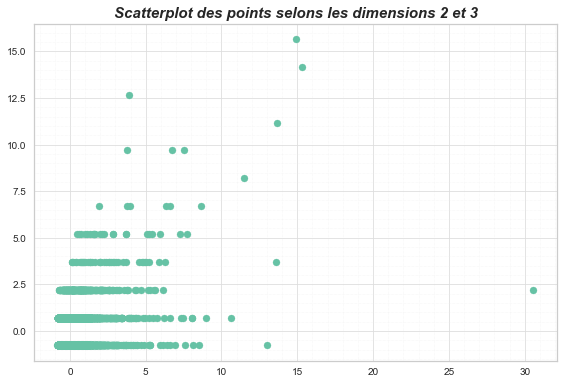

In [104]:
plt.figure()
plt.scatter(X[:, 2], X[:, 3])
plt.title('Scatterplot des points selons les dimensions 2 et 3', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

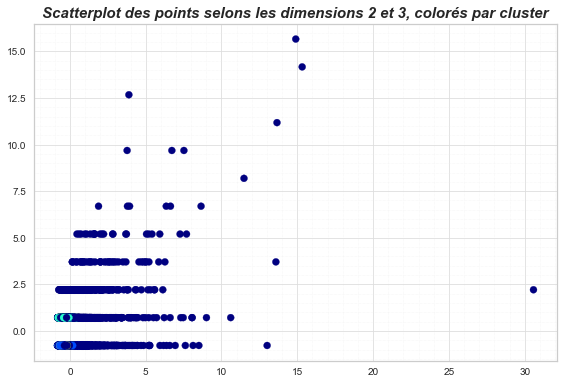

In [105]:
plt.figure()
plt.scatter(
    X[:, 2],
    X[:, 3],
    c = y_pred,
    cmap = plt.get_cmap('jet')
    )
plt.title('Scatterplot des points selons les dimensions 2 et 3, colorés par cluster', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

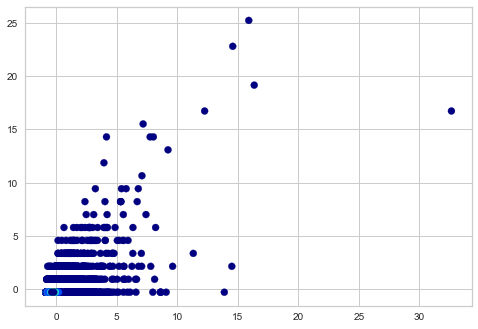

In [106]:
plt.figure()
plt.scatter(
    df_dbscan['payment_value'],
    df_dbscan['Nb_commandes'],
    c = y_pred,
    cmap = plt.get_cmap('jet')
    )
plt.show()

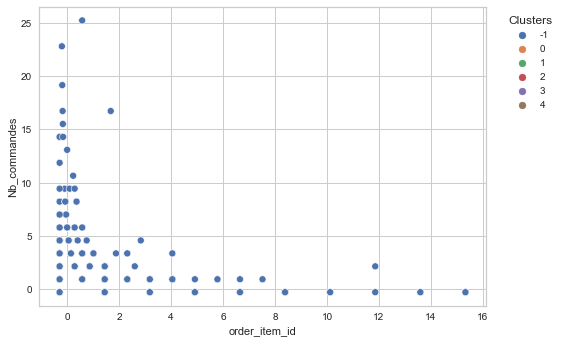

In [107]:
plt.figure()
p = sns.scatterplot(
    data = df_dbscan,
    x = 'order_item_id',
    y = 'Nb_commandes',
    hue = db_labels,
    legend = 'full',
    palette = 'deep'
    )
sns.move_legend(p, 'upper right', bbox_to_anchor = (1.17, 1.), title = 'Clusters')
plt.show()

In [108]:
########## Conclusions ##########

# de base pas adapté car obligé d'utiliser un jeu de données réduit (df_sampled)

list_methode.append('DBSCAN')
list_variables.append(df_dbscan.shape[1])
list_clients.append(df_dbscan.shape[0])
list_n_clusters.append(5)
list_silhouette_score.append(silhouette_dbscan)

## Spectral clustering

In [109]:
df_spectral = df_sampled.copy()

In [110]:
%%time
# affinity matrix avec kernel Gaussien
# -> 'affinity' = 'rbf'

# Building the clustering model
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity = 'rbf')

# Training the model and Storing the predicted cluster labels
labels_rbf = spectral_model_rbf.fit_predict(df_spectral)

CPU times: user 4min 54s, sys: 6.51 s, total: 5min
Wall time: 4min 39s


In [111]:
# Evaluation du clustering : silhouette score
silhouette_spectral_rbf = round(silhouette_score(df_spectral, labels_rbf), 2)
print('The average silhouette score is:', silhouette_spectral_rbf)

The average silhouette score is: 0.91


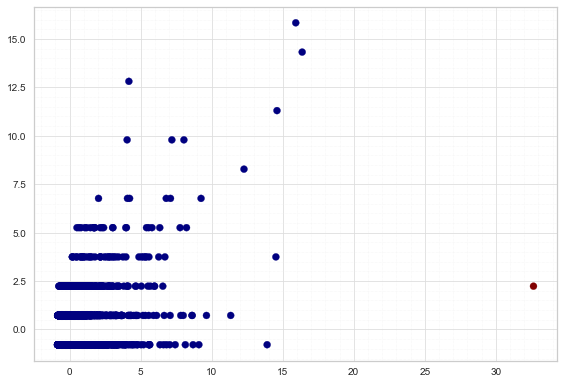

In [112]:
# Visualizing the clustering (MANQUE TITRE)
plt.figure()
plt.scatter(
    df_spectral['payment_value'],
    df_spectral['review'],
    c = SpectralClustering(n_clusters = 4, affinity = 'rbf').fit_predict(df_spectral),
    cmap = plt.get_cmap('jet')
    )
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [113]:
%%time
# -> affinity = ‘nearest_neighbors’

# Building the clustering model
spectral_model_nn = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors')

# Training the model and Storing the predicted cluster labels
labels_nn = spectral_model_nn.fit_predict(df_spectral)

CPU times: user 2.07 s, sys: 445 ms, total: 2.51 s
Wall time: 1.42 s


In [114]:
# Evaluation du clustering : silhouette score
silhouette_spectral_nn = round(silhouette_score(df_spectral, labels_nn), 2)
print('The average silhouette score is:', silhouette_spectral_nn)

The average silhouette score is: 0.14


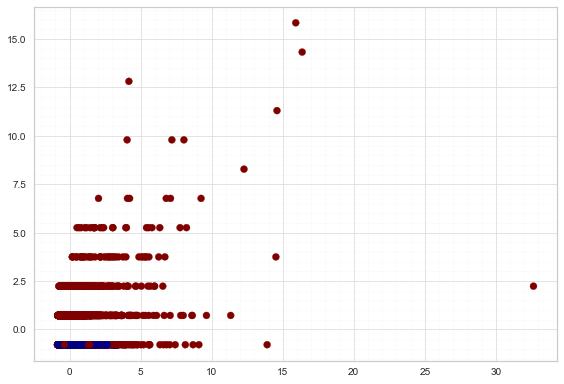

In [115]:
# Visualizing the clustering (MANQUE TITRE)
plt.figure()
plt.scatter(
    df_spectral['payment_value'],
    df_spectral['review'],
    c = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors').fit_predict(df_spectral),
    cmap = plt.get_cmap('jet')
    )
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [116]:
# Evaluer performances

# List of different values of affinity
affinity = ['rbf', 'nearest-neighbours']

# List of Silhouette Scores
s_scores = []

# Evaluating the performance
s_scores.append(silhouette_score(df_spectral, labels_rbf))
s_scores.append(silhouette_score(df_spectral, labels_nn))

print(s_scores)

[0.9143826699778712, 0.14198012135359764]


In [117]:
########## Conclusions ##########

list_methode.append('Spectral clustering')
list_variables.append(df_spectral.shape[1])
list_clients.append(df_spectral.shape[0])
list_n_clusters.append(5)
list_silhouette_score.append(silhouette_spectral_nn)

## Agglomerative clustering

In [161]:
# = clustering hiérarchique
# algo forme clusters en mesurant dissimilarité entre les données

df_agglomerative = df_sampled.copy()
df_agglomerative

,product_weight_g,payment_sequential,payment_value,review,distance,Nb_commandes,order_item_id,customer_city,payment_type
0,-0.574236,-0.143138,-0.672755,-0.786379,0.979350,-0.277944,-0.292940,0,0
1,-0.378839,-0.143138,-0.025947,-0.786379,-0.229303,0.936986,-0.292940,0,1
2,-0.518408,-0.143138,-0.239106,-0.786379,-0.503987,-0.277944,-0.292940,1,1
3,-0.406752,1.979736,-0.363306,-0.786379,-0.286663,-0.277944,-0.292940,0,1
4,-0.544461,-0.143138,-0.643037,-0.786379,-1.016612,-0.277944,-0.292940,0,1
...,...,...,...,...,...,...,...,...,...
8607,-0.590240,-0.143138,-0.424209,0.724822,0.112824,-0.277944,-0.292940,0,1
8608,-0.388143,-0.143138,3.746294,-0.786379,-0.447018,-0.277944,4.915393,0,1
8609,-0.202050,1.979736,-0.363306,-0.786379,0.923694,-0.277944,-0.292940,1,1
8610,-0.376978,-0.143138,8.688733,-0.786379,-0.837016,-0.277944,-0.292940,0,1


In [119]:
# Create a hierarchical clustering model
hiercluster = AgglomerativeClustering(
    affinity = 'euclidean',
    linkage = 'ward',
    compute_full_tree = True
    )

In [120]:
%time

# Test sur jeu de données complet -> kernel crash

# Tentative d'itération pour trouver la comvbinaison de paramètre optimale (en cours)
"""
# Test sur jeu données sous-échantillonné :
agglo_clusters = []
list_metric = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed'], # nouveau nom de 'affinity'
list_linkage = ['ward', 'complete', 'average', 'single']

n_iterations = 0
for m in list_metric:
    for l in list_linkage:
        hiercluster_grid = AgglomerativeClustering(affinity = m, linkage = l)
        # fit transform
        clusters = hiercluster_grid.fit_predict(X = df_agglomerative)
        # saving the number of clusters
        n_clusters = len(set(clusters))
        # counting the amount of data in each clusters
        cluster_count = Counter(clusters)
        # inscrising n iter
        n_iterations += 1
        # concerver valeurs pour lesquelles on obtient 2 à 9 clusters contenants au moins 500 individus
        if n_clusters > 2 and n_clusters < 15 and all(element >= 500 for element in [cluster_count[c] for c in cluster_count.keys()]):
            #print(f'Conditions vérifiée !! Paramètres epsilon = {eps_val}, min_samples = {min_s} ')
            agglo_clusters.append([m, l, n_clusters, cluster_count])
        else:
            pass
            #print(f'Paramètres epsilon = {eps_val}, min_samples = {min_s} non retenus - {n_clusters} clusters, balance : {cluster_count}')

print(f"Nombre d'itérations effectuées : {n_iterations}")
print('Paramètres et nombre de clusters retenus :')
agglo_clusters"""

CPU times: user 0 ns, sys: 1e+03 ns, total: 1e+03 ns
Wall time: 3.1 µs


'\n# Test sur jeu données sous-échantillonné :\nagglo_clusters = []\nlist_metric = [\'euclidean\', \'l1\', \'l2\', \'manhattan\', \'cosine\', \'precomputed\'], # nouveau nom de \'affinity\'\nlist_linkage = [\'ward\', \'complete\', \'average\', \'single\']\n\nn_iterations = 0\nfor m in list_metric:\n    for l in list_linkage:\n        hiercluster_grid = AgglomerativeClustering(affinity = m, linkage = l)\n        # fit transform\n        clusters = hiercluster_grid.fit_predict(X = df_agglomerative)\n        # saving the number of clusters\n        n_clusters = len(set(clusters))\n        # counting the amount of data in each clusters\n        cluster_count = Counter(clusters)\n        # inscrising n iter\n        n_iterations += 1\n        # concerver valeurs pour lesquelles on obtient 2 à 9 clusters contenants au moins 500 individus\n        if n_clusters > 2 and n_clusters < 15 and all(element >= 500 for element in [cluster_count[c] for c in cluster_count.keys()]):\n            #print(

In [121]:
# Test avec jeu de données complet (df_reduit) -> kernel crashed while executing code
# Test avec jeu de données échantillonné (df_sampled):

# Fit the data to the model and determine which clusters each data point belongs to:
hiercluster.set_params(n_clusters = 5) # pour trouver 5 clusters
clusters_5 = hiercluster.fit_predict(df_agglomerative)
np.bincount(clusters_5) # count of data points in each cluster

array([6933,  144,  737,  748,   50])

In [122]:
# Evaluation du clustering : silhouette score
silhouette_agglo_5 = round(silhouette_score(df_agglomerative, clusters_5), 2)
print('The average silhouette score is:', silhouette_agglo_5)

The average silhouette score is: 0.31


In [123]:
# 3 clusters:
hiercluster.set_params(n_clusters = 3)
clusters_3 = hiercluster.fit_predict(df_agglomerative)
np.bincount(clusters_3)

array([7731,  144,  737])

In [124]:
# Evaluation du clustering : silhouette score
silhouette_agglo_3 = round(silhouette_score(df_agglomerative, clusters_3), 2)
print('The average silhouette score is:', silhouette_agglo_3)

The average silhouette score is: 0.31


In [125]:
# Add cluster number to the original data
df_sampled_clustered = pd.DataFrame(
    df_agglomerative,
    columns = df_agglomerative.columns,
    index = df_agglomerative.index
    )

df_sampled_clustered['cluster'] = clusters_3
df_sampled_clustered.head()

,product_weight_g,payment_sequential,payment_value,review,distance,Nb_commandes,order_item_id,customer_city,payment_type,cluster
0,-0.574236,-0.143138,-0.672755,-0.786379,0.979350,-0.277944,-0.29294,0,0,0
1,-0.378839,-0.143138,-0.025947,-0.786379,-0.229303,0.936986,-0.29294,0,1,0
2,-0.518408,-0.143138,-0.239106,-0.786379,-0.503987,-0.277944,-0.29294,1,1,0
3,-0.406752,1.979736,-0.363306,-0.786379,-0.286663,-0.277944,-0.29294,0,1,0
4,-0.544461,-0.143138,-0.643037,-0.786379,-1.016612,-0.277944,-0.29294,0,1,0


In [126]:
# Find the size of the clusters
df_sampled_clustered['cluster'].value_counts()

0    7731
2     737
1     144
Name: cluster, dtype: int64

In [127]:
def plot_dendrogram(Z, names, figsize = (10, 25)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize = figsize)
    plt.title('Hierarchical Clustering Dendrogram', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = 'left',
    )
    plt.show()

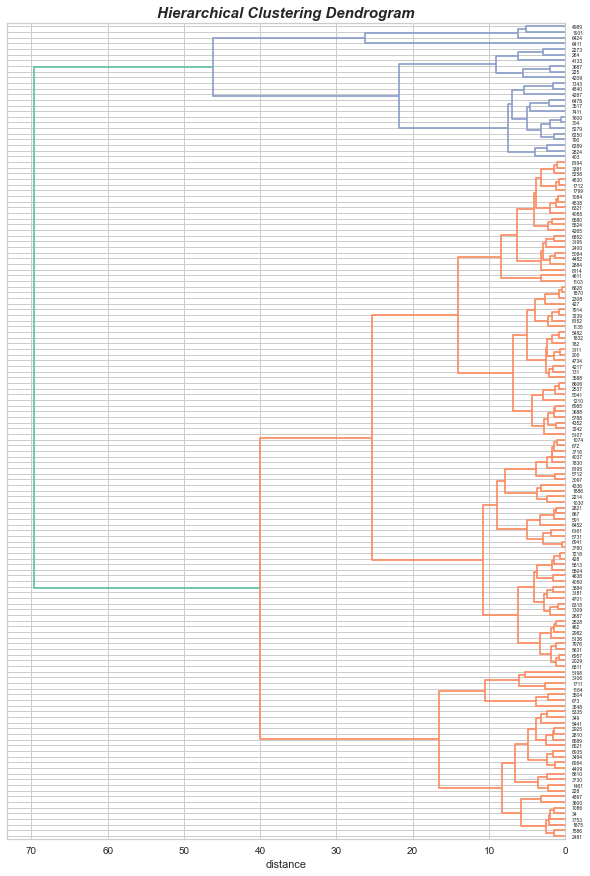

In [128]:
# Show a dendrogram, just for the first smallest cluster

sample = df_sampled_clustered[df_sampled_clustered.cluster == 1] # prendre le cluster 4 car celui avec le moins d'échantillons donc sera plus lisible
Z = linkage(sample, 'ward')
names = sample.index
plot_dendrogram(Z, names, figsize = (10, 15))

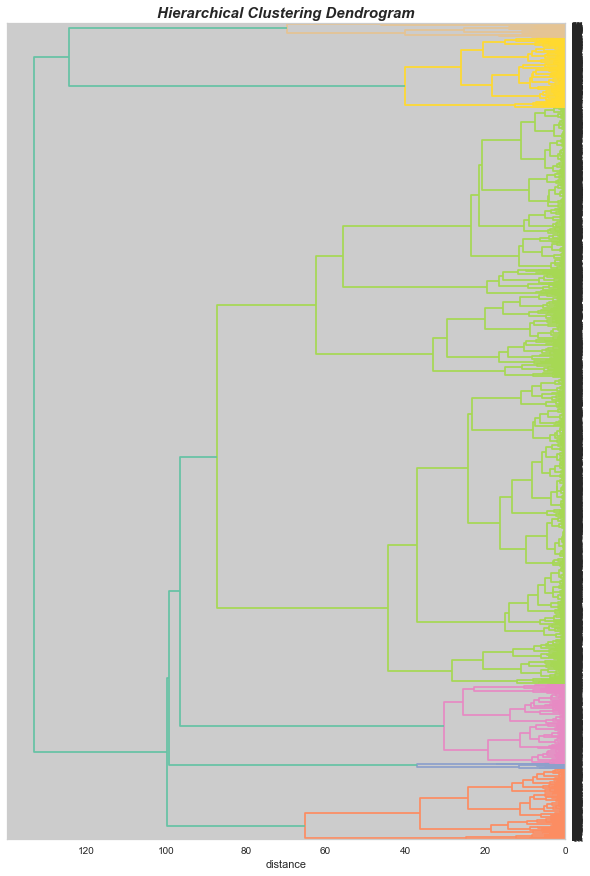

In [129]:
sample = df_agglomerative
Z = linkage(sample, 'ward')
names = sample.index
plot_dendrogram(Z, names, figsize = (10, 15))

Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 86119.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 43060 ticks ([1.0, ..., 

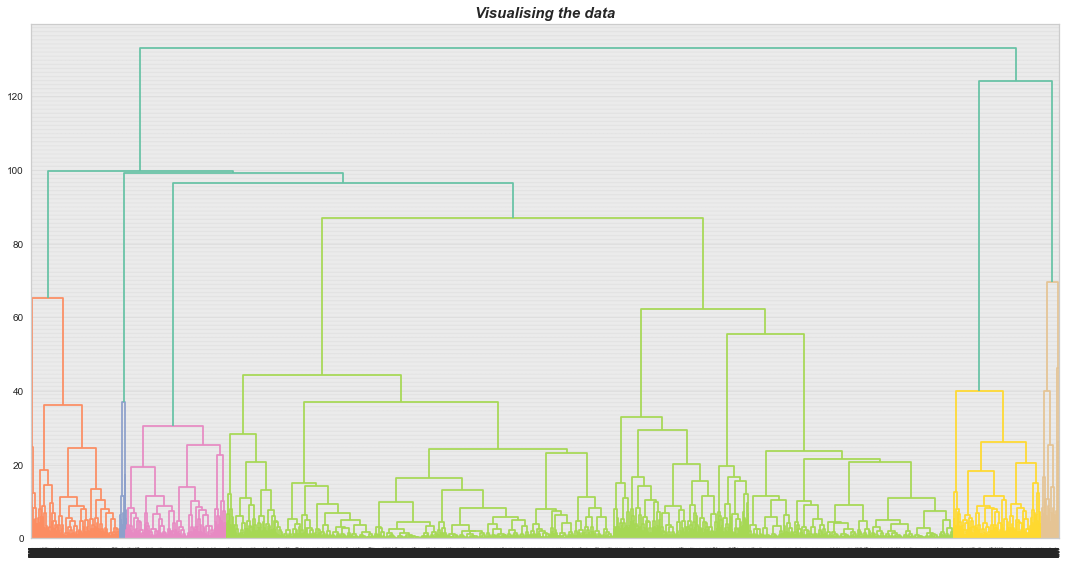

In [130]:
plt.figure(figsize = (15, 8))
plt.title('Visualising the data', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
Dendrogram = shc.dendrogram((shc.linkage(df_agglomerative, method = 'ward')))
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [131]:
########## Conclusions ##########

# résultat doit être à peu près similaire à ce qu'on option avec kmeans
# or on a du beaucoup réduire jeu de données donc trop contraignant donc pas adapté à notre situation donc on abandonne

list_methode.append('Agglomerative clustering')
list_variables.append(df_agglomerative.shape[1])
list_clients.append(df_agglomerative.shape[0])
list_n_clusters.append(3)
list_silhouette_score.append(silhouette_agglo_3)

## Comparaison des méthodes de clustering

In [132]:
df_comparaison = pd.DataFrame()
df_comparaison['Méthode'] = list_methode
df_comparaison['Nb de variables'] = list_variables
df_comparaison['Nb clients'] = list_clients
df_comparaison['Nb clusters'] = list_n_clusters
df_comparaison['Silhouette score'] = list_silhouette_score

df_comparaison

,Méthode,Nb de variables,Nb clients,Nb clusters,Silhouette score
0,RFM,3,118686,7,NaN
1,Kmeans,9,86120,3,0.34
2,DBSCAN,9,8612,5,-0.03
3,Spectral clustering,9,8612,5,0.14
4,Agglomerative clustering,10,8612,3,0.31


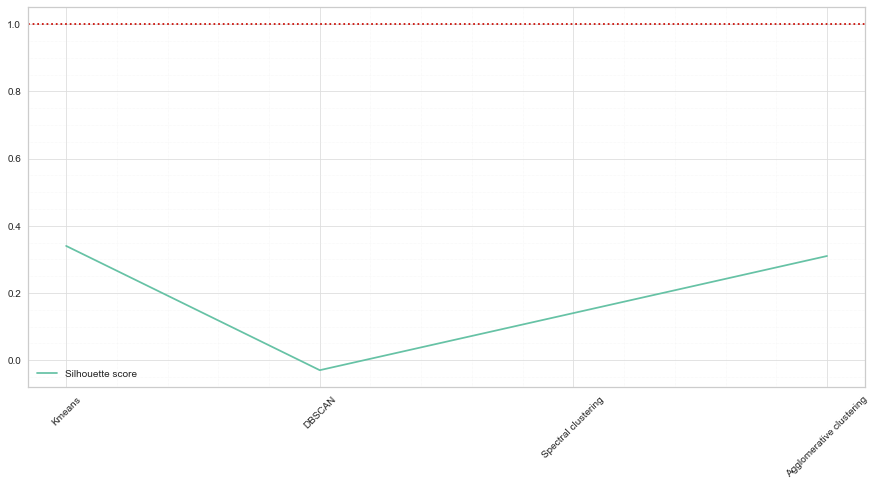

In [133]:
# plot results
plt.figure(figsize = (15, 7))
plt.plot(df_comparaison['Méthode'], df_comparaison['Silhouette score'], label = 'Silhouette score')
plt.axhline(y = 1, color = 'r', linestyle = ':')
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 45)
plt.show()

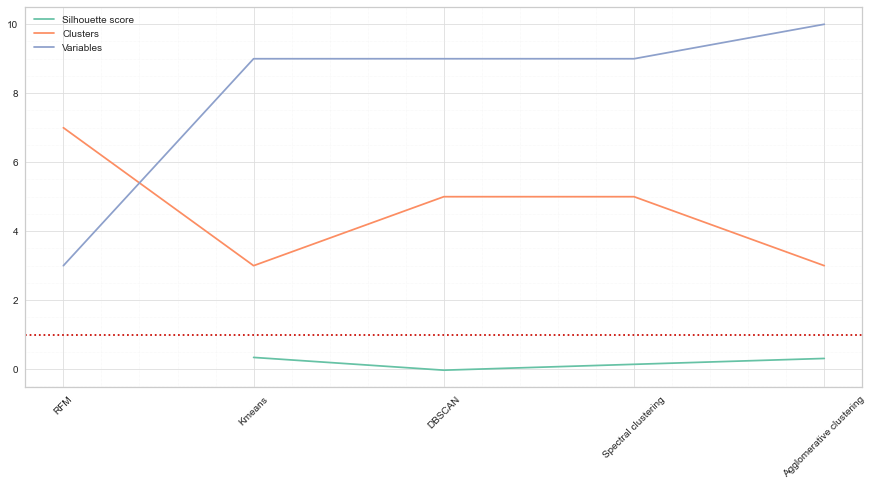

In [134]:
# plot results
plt.figure(figsize = (15, 7))
plt.plot(df_comparaison['Méthode'], df_comparaison['Silhouette score'], label = 'Silhouette score')
plt.plot(df_comparaison['Méthode'], df_comparaison['Nb clusters'], label = 'Clusters')
plt.axhline(y = 1, color = 'r', linestyle = ':')
plt.plot(df_comparaison['Méthode'], df_comparaison['Nb de variables'], label = 'Variables')
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 45)
plt.show()

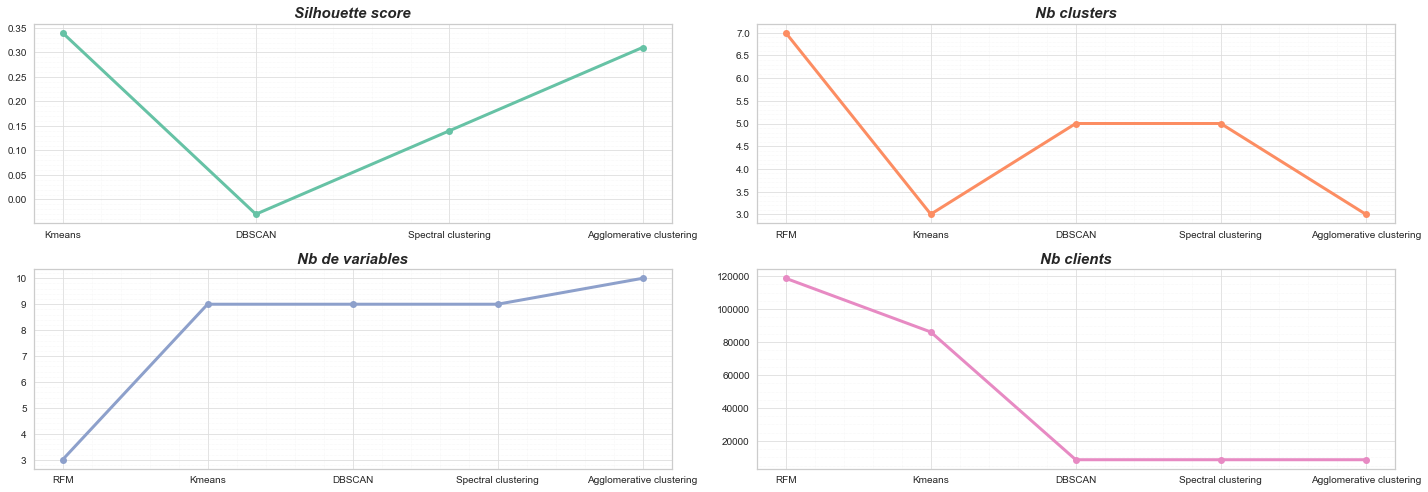

In [135]:
features = df_comparaison[['Silhouette score', 'Nb clusters', 'Nb de variables', 'Nb clients']]
couleurs = []

plt.figure(figsize = (20, 7))
i = 0
for y in features:
    plt.subplot(2, 2, 1 + i)
    plt.plot(df_comparaison['Méthode'], df_comparaison[y], c = sns.color_palette('Set2').as_hex()[i], linewidth = 3, marker = 'o', linestyle = '-')
    plt.title(f'{y}', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
    plt.grid(which='major', color='#DDDDDD', linewidth = 0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle = ':', linewidth = 0.5)
    plt.minorticks_on()
    i += 1

plt.tight_layout()
plt.show()

## Kmeans sur jeu de données total

In [150]:
df_final_kmeans = df_final.drop(['Date_achat'], axis = 1)

In [151]:
model = KMeans(
    n_clusters = 3,
    n_init = 15,
    max_iter = 100,
    init = 'k-means++',
    tol = 0.01,
    algorithm = 'auto',
    random_state = 100
    )

# Entrainer le modèle
model.fit(df_final_kmeans)
model.predict(df_final_kmeans)

array([0, 0, 1, ..., 0, 1, 1], dtype=int32)

In [152]:
########## SILHOUETTE SCORE ##########
# évaluation de la qualité du clustering
# A score closer to 1 indicates that the clustering is good, while a score closer to -1 indicates that the clustering is bad.
silhouette_kmeans_tot = round(silhouette_score(df_final_kmeans, model.fit_predict(df_final_kmeans)), 2)
print('The average silhouette score is:', silhouette_kmeans_tot)

The average silhouette score is: 0.21


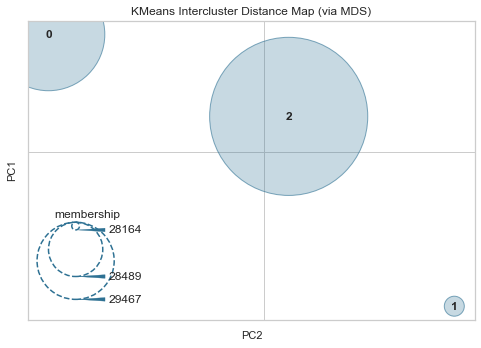

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [153]:
########## Distance intercluster ##########
# Intercluster distance Map with best k

distance_visualizer = InterclusterDistance(KMeans(3))
distance_visualizer.fit(df_final_kmeans)
distance_visualizer.show()

In [159]:
model.labels_

array([0, 0, 1, ..., 0, 1, 1], dtype=int32)

In [160]:
# Ajouter les clusters et observer leur comportement
labels = model.labels_
df_final_kmeans['cluster_num'] = labels
df_final_kmeans.head()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,payment_sequential,payment_installments,payment_value,review_score,review_time,order_time,delivery_error_time,order_preparation_time,shipping_limit_respect,review,distance,Nb_commandes,order_item_id,customer_city,customer_state,payment_type,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,product_category_Eletronique et Divertissement,"product_category_Fashion, Beauté & Santé",product_category_Maison & jardin,"product_category_Travail de bureau, Industry & Construction",cluster_num
0,1.167257,0.647319,-0.733865,-0.365812,-0.143138,0.072079,-0.658141,-1.725903,0.205285,-0.322790,-0.512780,1.001188,1.086596,0.724822,-0.783157,-0.277944,1.443171,0,1,1,2017.0,7.0,2.0,19.0,14.0,0,0,1,0,0
1,0.957866,1.327616,1.127941,1.305305,-0.143138,0.072079,-0.377872,0.685295,-0.253485,1.630269,0.304691,-0.464521,0.375678,-0.786379,0.513163,-0.277944,-0.292940,0,1,1,2018.0,2.0,2.0,14.0,11.0,0,1,0,0,0
2,1.062562,-0.487068,-0.733865,-0.276487,-0.143138,0.859505,-0.230308,-2.529636,-0.272668,-1.216744,-1.169459,-0.201061,1.140727,0.724822,-1.090666,-0.277944,1.443171,0,0,1,2018.0,5.0,5.0,26.0,12.0,0,0,0,1,1
3,1.271953,-0.537336,-0.733865,-0.537018,-0.143138,-0.715348,-0.541615,0.685295,-0.208044,-0.451719,-0.215734,-0.712737,0.602305,-0.786379,-0.299902,-0.277944,-0.292940,0,0,1,2017.0,4.0,0.0,3.0,23.0,1,0,0,0,2
4,-0.821955,-0.590956,-0.113263,-0.443599,-0.143138,0.859505,0.126602,-0.118437,-0.243696,0.345692,-0.670216,0.588430,-0.191630,0.724822,0.208500,-0.277944,-0.292940,0,1,1,2018.0,6.0,0.0,11.0,13.0,1,0,0,0,0


In [156]:
df_final_kmeans['cluster_num'].value_counts()

0    29124
1    28914
2    28082
Name: cluster_num, dtype: int64

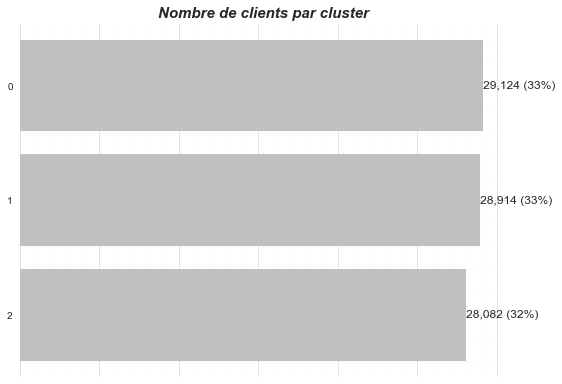

In [146]:
# Nombre de clients dans chaque cluster
segments_counts = df_final_kmeans['cluster_num'].value_counts().sort_values(ascending = True)

# Plot
fig, ax = plt.subplots()
bars = ax.barh(
        range(len(segments_counts)),
        segments_counts,
        color = 'silver'
        )
ax.set_frame_on(False)
ax.tick_params(left = False, bottom = False, labelbottom = False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)
for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value), int(value*100/segments_counts.sum())),
                va = 'center',
                ha = 'left'
               )
plt.title('Nombre de clients par cluster', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

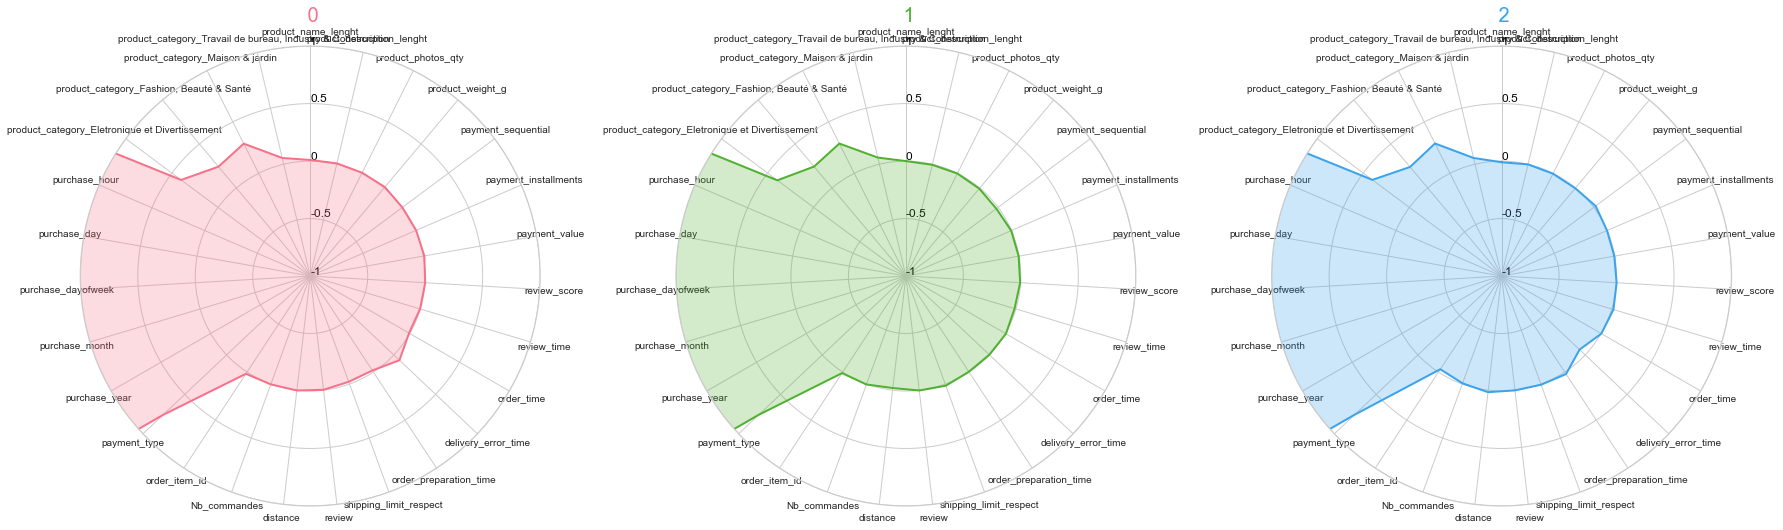

In [147]:
########## Radar plot ##########

clusters_customers_tot = df_final_kmeans['cluster_num'].unique()

# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette('husl', len(clusters_customers_tot))
colors = {label: color for label, color in zip(clusters_customers_tot, palette_1.as_hex())}

# Aggrégation par moyenne des valeurs par segment (A faire pour aller plus loin -> trouver un autre moyen d'agg que la moyenne)
df_plot = df_final_kmeans.groupby(['cluster_num']).agg('mean')

# Noms des variables
categories = list(df_plot.columns)

# Nombre de variables
N = len(categories)

# Définir l'angle entre chaque axe
# -> On divise un tour complet par le nombre de variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(1, figsize = (25, 15))

# Trace un radar chart pour chaque segment
for i, segment in enumerate(df_final_kmeans['cluster_num'].unique()):
    ax = fig.add_subplot(1, 3, i + 1, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Tracer un axe par variable et ajouter les labels
    plt.xticks(angles[:-1], categories)
    plt.yticks(color = 'grey', size = 2)
    values = list(df_plot.loc[segment].values)
    values += values[:1]
    ax.plot(angles, values, colors[segment], 'o-', linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, colors[segment], alpha = 0.25)
    plt.yticks([-1, -0.5, 0, 0.5, 1], ['-1', '-0.5', '0', '0.5', '1'], color = 'black', size = 12)
    ax.set_title(f' {segment}', size = 20, color = colors[segment])
    ax.grid(True)
    plt.ylim(-1, 1)
plt.tight_layout()
plt.show()